# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=150  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=1, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 9 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=4,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        w= w.mean(dim=0,keepdim=True)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

## MobileNet V2

In [3]:
'''MobileNetV2 in PyTorch.
See the paper "Inverted Residuals and Linear Bottlenecks:
Mobile Networks for Classification, Detection and Segmentation" for more details.
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride==1 else out
        return out


class MobileNetV2(nn.Module):
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 1),
           (6,  24, 2, 1),  # NOTE: change stride 2 -> 1 for CIFAR10
           (6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1),
           (6, 160, 3, 2),
           (6, 320, 1, 1)]

    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        # NOTE: change conv1 stride 2 -> 1 for CIFAR10
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.linear = nn.Linear(1280, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.relu(self.bn2(self.conv2(out)))
        # NOTE: change pooling kernel_size 7 -> 4 for CIFAR10
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNetV2(10).cuda()
else:
    model=MobileNetV2(10)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 10*show_step == 0:
            if batch_idx % 50*show_step == 0:
                print(model.conv2.weight.shape)
                print(torch.sum(torch.abs(model.conv2.weight)))
                print(model.conv2.weight)
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1=open("Cifar10_INFO.txt","a+")
            f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
            f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
    f1=open("Cifar10_INFO.txt","a+")
    f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
# writer = SummaryWriter()
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

torch.Size([1280, 320, 1, 1])
tensor(11799.7725, device='cuda:0')
Parameter containing:
tensor([[[[ 5.6523e-02]],

         [[-1.8127e-02]],

         [[ 5.2632e-02]],

         ...,

         [[ 4.1512e-02]],

         [[-2.3346e-02]],

         [[-1.6651e-02]]],


        [[[ 3.7911e-02]],

         [[ 4.3894e-02]],

         [[-2.8721e-02]],

         ...,

         [[ 1.7616e-02]],

         [[-2.8315e-02]],

         [[-5.4875e-02]]],


        [[[ 6.9653e-03]],

         [[ 3.6814e-02]],

         [[-4.4473e-03]],

         ...,

         [[-5.6850e-02]],

         [[ 2.1573e-02]],

         [[-4.2067e-02]]],


        ...,


        [[[-4.4787e-02]],

         [[-3.0187e-02]],

         [[ 6.0409e-02]],

         ...,

         [[-3.3301e-02]],

         [[-2.3661e-02]],

         [[ 4.5110e-02]]],


        [[[-3.0243e-03]],

         [[ 6.3308e-02]],

         [[-5.6516e-02]],

         ...,

         [[ 4.2090e-02]],

         [[-2.4419e-03]],

         [[-5.4518e-02]]],


  

Train Epoch: 1 [15360/50000 (34%)]	Loss: 1.361785, Accuracy: 49.22
Train Epoch: 1 [17920/50000 (40%)]	Loss: 1.426539, Accuracy: 47.66
Train Epoch: 1 [20480/50000 (45%)]	Loss: 1.264431, Accuracy: 48.83
Train Epoch: 1 [23040/50000 (51%)]	Loss: 1.281540, Accuracy: 54.69
torch.Size([1280, 320, 1, 1])
tensor(28661.2734, device='cuda:0')
Parameter containing:
tensor([[[[ 1.6555e-01]],

         [[ 2.1743e-02]],

         [[-1.3017e-02]],

         ...,

         [[ 1.6813e-01]],

         [[-9.6327e-03]],

         [[ 6.6666e-02]]],


        [[[-1.3071e-02]],

         [[ 1.2239e-01]],

         [[-1.2508e-01]],

         ...,

         [[-2.3358e-02]],

         [[-9.2169e-02]],

         [[-6.4951e-02]]],


        [[[ 7.0676e-02]],

         [[ 1.0885e-01]],

         [[-4.4202e-02]],

         ...,

         [[-4.0303e-02]],

         [[ 1.0310e-01]],

         [[-4.7291e-02]]],


        ...,


        [[[-1.8348e-02]],

         [[ 1.0188e-01]],

         [[-4.6404e-04]],

         ..

Train Epoch: 2 [40960/50000 (91%)]	Loss: 0.940766, Accuracy: 66.41
Train Epoch: 2 [43520/50000 (97%)]	Loss: 1.067005, Accuracy: 60.94

Validation set: Average loss: 2.7875, Accuracy: 1398/5000 (27.00%)

the time of this epoch:[39.08711338043213 s]
torch.Size([1280, 320, 1, 1])
tensor(32595.1777, device='cuda:0')
Parameter containing:
tensor([[[[ 1.8188e-01]],

         [[ 5.8663e-02]],

         [[ 3.6868e-02]],

         ...,

         [[ 2.0999e-01]],

         [[-6.3309e-02]],

         [[ 2.1594e-03]]],


        [[[-4.1194e-02]],

         [[ 1.5671e-01]],

         [[-9.7686e-03]],

         ...,

         [[-5.4885e-02]],

         [[-1.1033e-01]],

         [[ 2.7139e-02]]],


        [[[ 7.1634e-02]],

         [[ 1.0594e-01]],

         [[-4.2340e-02]],

         ...,

         [[-3.7363e-02]],

         [[ 1.0385e-01]],

         [[-1.8576e-02]]],


        ...,


        [[[ 2.1255e-02]],

         [[ 1.5011e-01]],

         [[-1.0906e-02]],

         ...,

         [[ 4.76

Train Epoch: 4 [15360/50000 (34%)]	Loss: 0.817603, Accuracy: 71.48
Train Epoch: 4 [17920/50000 (40%)]	Loss: 0.839962, Accuracy: 69.14
Train Epoch: 4 [20480/50000 (45%)]	Loss: 0.736784, Accuracy: 73.44
Train Epoch: 4 [23040/50000 (51%)]	Loss: 0.838292, Accuracy: 71.09
torch.Size([1280, 320, 1, 1])
tensor(36358.0781, device='cuda:0')
Parameter containing:
tensor([[[[ 1.8368e-01]],

         [[ 3.3771e-02]],

         [[ 1.4188e-01]],

         ...,

         [[ 2.4225e-01]],

         [[-8.2467e-02]],

         [[ 4.3689e-02]]],


        [[[-5.3473e-02]],

         [[ 1.8923e-01]],

         [[-2.8448e-02]],

         ...,

         [[-6.8646e-02]],

         [[-8.9734e-02]],

         [[ 7.9608e-02]]],


        [[[ 7.4304e-02]],

         [[ 1.0345e-01]],

         [[-4.4955e-02]],

         ...,

         [[-3.7453e-02]],

         [[ 9.8348e-02]],

         [[-3.5695e-02]]],


        ...,


        [[[ 5.8441e-02]],

         [[ 1.5797e-01]],

         [[-6.6571e-02]],

         ..

Train Epoch: 5 [40960/50000 (91%)]	Loss: 0.529700, Accuracy: 80.08
Train Epoch: 5 [43520/50000 (97%)]	Loss: 0.694690, Accuracy: 80.47

Validation set: Average loss: 3.3462, Accuracy: 762/5000 (15.00%)

the time of this epoch:[39.79112720489502 s]
torch.Size([1280, 320, 1, 1])
tensor(39415.0352, device='cuda:0')
Parameter containing:
tensor([[[[ 1.9773e-01]],

         [[ 4.2877e-02]],

         [[ 1.5174e-01]],

         ...,

         [[ 3.0170e-01]],

         [[-5.5168e-02]],

         [[-6.7580e-02]]],


        [[[-3.5236e-02]],

         [[ 2.4005e-01]],

         [[-1.0692e-01]],

         ...,

         [[-7.6130e-02]],

         [[-1.8018e-02]],

         [[ 1.2915e-01]]],


        [[[ 7.4590e-02]],

         [[ 1.0371e-01]],

         [[-4.5438e-02]],

         ...,

         [[-3.8779e-02]],

         [[ 9.7830e-02]],

         [[-4.0039e-02]]],


        ...,


        [[[ 7.4116e-02]],

         [[ 1.6544e-01]],

         [[-1.2746e-01]],

         ...,

         [[ 2.841

Train Epoch: 7 [15360/50000 (34%)]	Loss: 0.649697, Accuracy: 76.17
Train Epoch: 7 [17920/50000 (40%)]	Loss: 0.625737, Accuracy: 79.69
Train Epoch: 7 [20480/50000 (45%)]	Loss: 0.639341, Accuracy: 79.30
Train Epoch: 7 [23040/50000 (51%)]	Loss: 0.836823, Accuracy: 71.88
torch.Size([1280, 320, 1, 1])
tensor(42250.5664, device='cuda:0')
Parameter containing:
tensor([[[[ 2.3677e-01]],

         [[ 8.6334e-02]],

         [[ 1.8256e-01]],

         ...,

         [[ 3.2927e-01]],

         [[-5.6324e-02]],

         [[-7.7526e-02]]],


        [[[-1.0572e-01]],

         [[ 1.8417e-01]],

         [[-2.3170e-01]],

         ...,

         [[-6.7600e-02]],

         [[-2.0993e-02]],

         [[ 2.1956e-01]]],


        [[[ 7.4569e-02]],

         [[ 1.0454e-01]],

         [[-4.5765e-02]],

         ...,

         [[-3.8884e-02]],

         [[ 9.6616e-02]],

         [[-4.1021e-02]]],


        ...,


        [[[ 7.4230e-02]],

         [[ 1.7548e-01]],

         [[-1.5793e-01]],

         ..

Train Epoch: 8 [40960/50000 (91%)]	Loss: 0.610939, Accuracy: 80.47
Train Epoch: 8 [43520/50000 (97%)]	Loss: 0.589296, Accuracy: 79.69

Validation set: Average loss: 4.2250, Accuracy: 784/5000 (15.00%)

the time of this epoch:[39.67616295814514 s]
torch.Size([1280, 320, 1, 1])
tensor(44813.0117, device='cuda:0')
Parameter containing:
tensor([[[[ 2.4786e-01]],

         [[ 8.4243e-02]],

         [[ 1.2627e-01]],

         ...,

         [[ 3.7983e-01]],

         [[-4.6201e-02]],

         [[-1.4431e-01]]],


        [[[-1.3108e-01]],

         [[ 1.6945e-01]],

         [[-3.2378e-01]],

         ...,

         [[-8.7696e-02]],

         [[-6.2090e-03]],

         [[ 2.8844e-01]]],


        [[[ 7.4695e-02]],

         [[ 1.0499e-01]],

         [[-4.6264e-02]],

         ...,

         [[-4.0636e-02]],

         [[ 9.5966e-02]],

         [[-4.3110e-02]]],


        ...,


        [[[ 1.2585e-01]],

         [[ 2.2266e-01]],

         [[-1.6751e-01]],

         ...,

         [[-1.981

Train Epoch: 10 [15360/50000 (34%)]	Loss: 0.525932, Accuracy: 83.59
Train Epoch: 10 [17920/50000 (40%)]	Loss: 0.584824, Accuracy: 81.25
Train Epoch: 10 [20480/50000 (45%)]	Loss: 0.601712, Accuracy: 81.64
Train Epoch: 10 [23040/50000 (51%)]	Loss: 0.441450, Accuracy: 83.98
torch.Size([1280, 320, 1, 1])
tensor(47166.0508, device='cuda:0')
Parameter containing:
tensor([[[[ 2.7831e-01]],

         [[ 9.3715e-02]],

         [[ 1.0964e-01]],

         ...,

         [[ 3.9618e-01]],

         [[-6.1068e-02]],

         [[-1.3995e-01]]],


        [[[-1.2529e-01]],

         [[ 1.7372e-01]],

         [[-4.1637e-01]],

         ...,

         [[-9.9328e-02]],

         [[ 5.3252e-02]],

         [[ 2.5389e-01]]],


        [[[ 7.4681e-02]],

         [[ 1.0496e-01]],

         [[-4.6295e-02]],

         ...,

         [[-4.0660e-02]],

         [[ 9.5936e-02]],

         [[-4.3218e-02]]],


        ...,


        [[[ 1.1023e-01]],

         [[ 2.4957e-01]],

         [[-2.1094e-01]],

       

Train Epoch: 11 [40960/50000 (91%)]	Loss: 0.434781, Accuracy: 84.38
Train Epoch: 11 [43520/50000 (97%)]	Loss: 0.514419, Accuracy: 79.69

Validation set: Average loss: 3.7200, Accuracy: 1051/5000 (21.00%)

the time of this epoch:[39.77223062515259 s]
torch.Size([1280, 320, 1, 1])
tensor(49044.4727, device='cuda:0')
Parameter containing:
tensor([[[[ 3.1393e-01]],

         [[ 1.0803e-01]],

         [[ 9.9395e-02]],

         ...,

         [[ 4.0735e-01]],

         [[-6.4560e-02]],

         [[-1.4892e-01]]],


        [[[-1.4149e-01]],

         [[ 2.1632e-01]],

         [[-3.2083e-01]],

         ...,

         [[-1.1888e-01]],

         [[ 2.8069e-02]],

         [[ 3.1993e-01]]],


        [[[ 7.4688e-02]],

         [[ 1.0496e-01]],

         [[-4.6277e-02]],

         ...,

         [[-4.0604e-02]],

         [[ 9.5934e-02]],

         [[-4.3169e-02]]],


        ...,


        [[[ 1.4839e-01]],

         [[ 3.0471e-01]],

         [[-1.1330e-01]],

         ...,

         [[-2.

Train Epoch: 13 [15360/50000 (34%)]	Loss: 0.492260, Accuracy: 83.20
Train Epoch: 13 [17920/50000 (40%)]	Loss: 0.516191, Accuracy: 82.03
Train Epoch: 13 [20480/50000 (45%)]	Loss: 0.485256, Accuracy: 86.33
Train Epoch: 13 [23040/50000 (51%)]	Loss: 0.463780, Accuracy: 84.38
torch.Size([1280, 320, 1, 1])
tensor(51329.3125, device='cuda:0')
Parameter containing:
tensor([[[[ 2.7036e-01]],

         [[ 4.6433e-02]],

         [[ 8.6084e-02]],

         ...,

         [[ 4.5879e-01]],

         [[-1.2525e-01]],

         [[-1.1583e-01]]],


        [[[-1.3170e-01]],

         [[ 2.4991e-01]],

         [[-4.2612e-01]],

         ...,

         [[-5.8032e-02]],

         [[ 9.9006e-02]],

         [[ 4.0465e-01]]],


        [[[ 7.4753e-02]],

         [[ 1.0507e-01]],

         [[-4.6342e-02]],

         ...,

         [[-4.1010e-02]],

         [[ 9.5638e-02]],

         [[-4.4906e-02]]],


        ...,


        [[[ 1.4860e-01]],

         [[ 3.0037e-01]],

         [[-1.7502e-01]],

       

Train Epoch: 14 [40960/50000 (91%)]	Loss: 0.443920, Accuracy: 85.55
Train Epoch: 14 [43520/50000 (97%)]	Loss: 0.512224, Accuracy: 82.42

Validation set: Average loss: 3.1108, Accuracy: 549/5000 (10.00%)

the time of this epoch:[39.19836902618408 s]
torch.Size([1280, 320, 1, 1])
tensor(53357.5000, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8826e-01]],

         [[ 9.3363e-02]],

         [[ 5.2649e-02]],

         ...,

         [[ 5.2124e-01]],

         [[-7.3934e-02]],

         [[-1.0668e-01]]],


        [[[-1.2505e-01]],

         [[ 2.6506e-01]],

         [[-4.7165e-01]],

         ...,

         [[-1.2056e-01]],

         [[ 1.1075e-01]],

         [[ 3.8531e-01]]],


        [[[ 7.4754e-02]],

         [[ 1.0508e-01]],

         [[-4.6342e-02]],

         ...,

         [[-4.1008e-02]],

         [[ 9.5638e-02]],

         [[-4.4905e-02]]],


        ...,


        [[[ 1.4411e-01]],

         [[ 3.6984e-01]],

         [[-1.1809e-01]],

         ...,

         [[-4.7

Train Epoch: 16 [15360/50000 (34%)]	Loss: 0.410258, Accuracy: 84.77
Train Epoch: 16 [17920/50000 (40%)]	Loss: 0.372431, Accuracy: 88.28
Train Epoch: 16 [20480/50000 (45%)]	Loss: 0.402811, Accuracy: 84.77
Train Epoch: 16 [23040/50000 (51%)]	Loss: 0.402452, Accuracy: 87.50
torch.Size([1280, 320, 1, 1])
tensor(55253.8477, device='cuda:0')
Parameter containing:
tensor([[[[ 3.1333e-01]],

         [[ 1.1252e-01]],

         [[ 1.9407e-02]],

         ...,

         [[ 5.3645e-01]],

         [[-6.6354e-02]],

         [[-6.8715e-02]]],


        [[[-3.7067e-02]],

         [[ 2.4841e-01]],

         [[-4.7016e-01]],

         ...,

         [[-1.0756e-01]],

         [[ 1.8480e-01]],

         [[ 4.0832e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1931e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 1.8902e-01]],

         [[ 3.3294e-01]],

         [[-2.1352e-01]],

       

Train Epoch: 17 [40960/50000 (91%)]	Loss: 0.422130, Accuracy: 86.72
Train Epoch: 17 [43520/50000 (97%)]	Loss: 0.434071, Accuracy: 85.16

Validation set: Average loss: 3.0224, Accuracy: 907/5000 (18.00%)

the time of this epoch:[39.786620140075684 s]
torch.Size([1280, 320, 1, 1])
tensor(57213.2578, device='cuda:0')
Parameter containing:
tensor([[[[ 3.7098e-01]],

         [[ 1.3661e-01]],

         [[ 4.7364e-02]],

         ...,

         [[ 5.2250e-01]],

         [[-4.1303e-02]],

         [[-1.4384e-01]]],


        [[[-5.7802e-02]],

         [[ 2.8031e-01]],

         [[-5.3912e-01]],

         ...,

         [[-1.3519e-01]],

         [[ 1.5938e-01]],

         [[ 4.3259e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1931e-02]],

         [[ 9.5293e-02]],

         [[-4.3628e-02]]],


        ...,


        [[[ 1.7244e-01]],

         [[ 3.4494e-01]],

         [[-2.6769e-01]],

         ...,

         [[-1.

Train Epoch: 19 [15360/50000 (34%)]	Loss: 0.384165, Accuracy: 87.50
Train Epoch: 19 [17920/50000 (40%)]	Loss: 0.308590, Accuracy: 88.67
Train Epoch: 19 [20480/50000 (45%)]	Loss: 0.469616, Accuracy: 85.55
Train Epoch: 19 [23040/50000 (51%)]	Loss: 0.419252, Accuracy: 85.94
torch.Size([1280, 320, 1, 1])
tensor(59133.1953, device='cuda:0')
Parameter containing:
tensor([[[[ 3.8462e-01]],

         [[ 1.6270e-01]],

         [[ 2.0881e-02]],

         ...,

         [[ 5.1596e-01]],

         [[-1.4303e-02]],

         [[-9.6923e-02]]],


        [[[-7.8492e-02]],

         [[ 2.5888e-01]],

         [[-5.8662e-01]],

         ...,

         [[-1.3094e-01]],

         [[ 1.9634e-01]],

         [[ 4.5637e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 2.0274e-01]],

         [[ 3.8224e-01]],

         [[-2.8564e-01]],

       

Train Epoch: 20 [40960/50000 (91%)]	Loss: 0.453716, Accuracy: 84.38
Train Epoch: 20 [43520/50000 (97%)]	Loss: 0.349493, Accuracy: 88.28

Validation set: Average loss: 7.0335, Accuracy: 589/5000 (11.00%)

the time of this epoch:[39.58933663368225 s]
torch.Size([1280, 320, 1, 1])
tensor(60712.7461, device='cuda:0')
Parameter containing:
tensor([[[[ 4.1377e-01]],

         [[ 1.7729e-01]],

         [[-1.4781e-02]],

         ...,

         [[ 5.2483e-01]],

         [[ 1.3140e-03]],

         [[-6.4289e-02]]],


        [[[-7.4020e-02]],

         [[ 2.2863e-01]],

         [[-6.4450e-01]],

         ...,

         [[-1.6454e-01]],

         [[ 2.5768e-01]],

         [[ 3.7497e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 2.3997e-01]],

         [[ 4.6343e-01]],

         [[-2.5134e-01]],

         ...,

         [[-9.7

Train Epoch: 22 [15360/50000 (34%)]	Loss: 0.345656, Accuracy: 86.33
Train Epoch: 22 [17920/50000 (40%)]	Loss: 0.231573, Accuracy: 91.02
Train Epoch: 22 [20480/50000 (45%)]	Loss: 0.272516, Accuracy: 91.80
Train Epoch: 22 [23040/50000 (51%)]	Loss: 0.230808, Accuracy: 92.58
torch.Size([1280, 320, 1, 1])
tensor(61156.3867, device='cuda:0')
Parameter containing:
tensor([[[[ 4.3762e-01]],

         [[ 1.9190e-01]],

         [[ 2.1436e-02]],

         ...,

         [[ 5.1903e-01]],

         [[ 2.8559e-02]],

         [[-2.7965e-02]]],


        [[[-7.8940e-02]],

         [[ 2.0254e-01]],

         [[-6.3828e-01]],

         ...,

         [[-1.5553e-01]],

         [[ 2.3166e-01]],

         [[ 4.3722e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 2.6168e-01]],

         [[ 4.7144e-01]],

         [[-2.4481e-01]],

       

Train Epoch: 23 [40960/50000 (91%)]	Loss: 0.237605, Accuracy: 92.19
Train Epoch: 23 [43520/50000 (97%)]	Loss: 0.271563, Accuracy: 91.41

Validation set: Average loss: 4.9384, Accuracy: 787/5000 (15.00%)

the time of this epoch:[39.54204273223877 s]
torch.Size([1280, 320, 1, 1])
tensor(61617.1250, device='cuda:0')
Parameter containing:
tensor([[[[ 4.2829e-01]],

         [[ 2.1464e-01]],

         [[-1.0323e-02]],

         ...,

         [[ 5.6005e-01]],

         [[-3.1438e-02]],

         [[-6.6237e-02]]],


        [[[-8.8675e-02]],

         [[ 2.1346e-01]],

         [[-6.8254e-01]],

         ...,

         [[-1.2261e-01]],

         [[ 2.4194e-01]],

         [[ 4.1263e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 2.3408e-01]],

         [[ 5.0098e-01]],

         [[-2.4390e-01]],

         ...,

         [[-9.7

Train Epoch: 25 [15360/50000 (34%)]	Loss: 0.223638, Accuracy: 93.36
Train Epoch: 25 [17920/50000 (40%)]	Loss: 0.236872, Accuracy: 92.19
Train Epoch: 25 [20480/50000 (45%)]	Loss: 0.168875, Accuracy: 93.75
Train Epoch: 25 [23040/50000 (51%)]	Loss: 0.228032, Accuracy: 91.41
torch.Size([1280, 320, 1, 1])
tensor(62278.8945, device='cuda:0')
Parameter containing:
tensor([[[[ 4.2803e-01]],

         [[ 2.2909e-01]],

         [[-2.0909e-02]],

         ...,

         [[ 5.8364e-01]],

         [[-3.3778e-02]],

         [[-4.1867e-02]]],


        [[[-4.8413e-02]],

         [[ 2.2473e-01]],

         [[-7.0719e-01]],

         ...,

         [[-1.2704e-01]],

         [[ 2.3628e-01]],

         [[ 4.1578e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 2.4859e-01]],

         [[ 5.1241e-01]],

         [[-2.3058e-01]],

       

Train Epoch: 26 [40960/50000 (91%)]	Loss: 0.241320, Accuracy: 89.45
Train Epoch: 26 [43520/50000 (97%)]	Loss: 0.277880, Accuracy: 89.06

Validation set: Average loss: 9.0018, Accuracy: 706/5000 (14.00%)

the time of this epoch:[39.59683704376221 s]
torch.Size([1280, 320, 1, 1])
tensor(62863.7930, device='cuda:0')
Parameter containing:
tensor([[[[ 4.4396e-01]],

         [[ 2.5546e-01]],

         [[ 4.7595e-02]],

         ...,

         [[ 5.5164e-01]],

         [[-1.7213e-02]],

         [[-6.3285e-02]]],


        [[[-4.7213e-02]],

         [[ 2.0441e-01]],

         [[-7.2129e-01]],

         ...,

         [[-1.2492e-01]],

         [[ 2.9220e-01]],

         [[ 4.0185e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 2.5707e-01]],

         [[ 5.4166e-01]],

         [[-1.9812e-01]],

         ...,

         [[-7.9

Train Epoch: 28 [15360/50000 (34%)]	Loss: 0.220765, Accuracy: 91.80
Train Epoch: 28 [17920/50000 (40%)]	Loss: 0.254246, Accuracy: 91.41
Train Epoch: 28 [20480/50000 (45%)]	Loss: 0.193244, Accuracy: 91.80
Train Epoch: 28 [23040/50000 (51%)]	Loss: 0.229952, Accuracy: 91.41
torch.Size([1280, 320, 1, 1])
tensor(63525.6523, device='cuda:0')
Parameter containing:
tensor([[[[ 4.3161e-01]],

         [[ 2.5980e-01]],

         [[ 3.9652e-02]],

         ...,

         [[ 5.1100e-01]],

         [[-1.0584e-02]],

         [[-8.2485e-02]]],


        [[[-7.2890e-02]],

         [[ 1.7861e-01]],

         [[-7.3032e-01]],

         ...,

         [[-1.7706e-01]],

         [[ 2.7144e-01]],

         [[ 3.5173e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 2.5642e-01]],

         [[ 5.4261e-01]],

         [[-2.0047e-01]],

       

Train Epoch: 29 [40960/50000 (91%)]	Loss: 0.176302, Accuracy: 93.36
Train Epoch: 29 [43520/50000 (97%)]	Loss: 0.216912, Accuracy: 89.84

Validation set: Average loss: 5.1184, Accuracy: 1277/5000 (25.00%)

the time of this epoch:[39.65569233894348 s]
torch.Size([1280, 320, 1, 1])
tensor(64162.3906, device='cuda:0')
Parameter containing:
tensor([[[[ 4.8634e-01]],

         [[ 3.2593e-01]],

         [[ 1.5916e-02]],

         ...,

         [[ 5.1286e-01]],

         [[-1.2931e-02]],

         [[-1.0738e-01]]],


        [[[-9.8637e-02]],

         [[ 1.6912e-01]],

         [[-7.2471e-01]],

         ...,

         [[-1.5007e-01]],

         [[ 2.5995e-01]],

         [[ 3.6613e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 2.5532e-01]],

         [[ 5.4455e-01]],

         [[-2.1249e-01]],

         ...,

         [[-7.

Train Epoch: 31 [15360/50000 (34%)]	Loss: 0.257812, Accuracy: 92.19
Train Epoch: 31 [17920/50000 (40%)]	Loss: 0.246628, Accuracy: 89.84
Train Epoch: 31 [20480/50000 (45%)]	Loss: 0.178525, Accuracy: 92.58
Train Epoch: 31 [23040/50000 (51%)]	Loss: 0.157868, Accuracy: 94.14
torch.Size([1280, 320, 1, 1])
tensor(64932.4531, device='cuda:0')
Parameter containing:
tensor([[[[ 5.0272e-01]],

         [[ 3.2776e-01]],

         [[-1.1984e-02]],

         ...,

         [[ 5.0625e-01]],

         [[-1.3155e-02]],

         [[-7.2279e-02]]],


        [[[-5.6677e-02]],

         [[ 2.2849e-01]],

         [[-7.1737e-01]],

         ...,

         [[-1.5122e-01]],

         [[ 2.4696e-01]],

         [[ 3.6557e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 2.3365e-01]],

         [[ 5.3227e-01]],

         [[-2.6242e-01]],

       

Train Epoch: 32 [40960/50000 (91%)]	Loss: 0.197998, Accuracy: 94.14
Train Epoch: 32 [43520/50000 (97%)]	Loss: 0.152950, Accuracy: 95.31

Validation set: Average loss: 12.1017, Accuracy: 685/5000 (13.00%)

the time of this epoch:[39.62647080421448 s]
torch.Size([1280, 320, 1, 1])
tensor(65651.5625, device='cuda:0')
Parameter containing:
tensor([[[[ 5.4003e-01]],

         [[ 3.8222e-01]],

         [[-3.5268e-02]],

         ...,

         [[ 5.2083e-01]],

         [[ 2.9224e-02]],

         [[-1.3223e-01]]],


        [[[-6.5930e-02]],

         [[ 2.1563e-01]],

         [[-7.4423e-01]],

         ...,

         [[-1.2168e-01]],

         [[ 2.7040e-01]],

         [[ 3.9851e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 2.0835e-01]],

         [[ 5.2679e-01]],

         [[-2.9576e-01]],

         ...,

         [[-5.

Train Epoch: 34 [15360/50000 (34%)]	Loss: 0.166351, Accuracy: 94.53
Train Epoch: 34 [17920/50000 (40%)]	Loss: 0.180376, Accuracy: 93.75
Train Epoch: 34 [20480/50000 (45%)]	Loss: 0.145869, Accuracy: 96.09
Train Epoch: 34 [23040/50000 (51%)]	Loss: 0.263535, Accuracy: 91.41
torch.Size([1280, 320, 1, 1])
tensor(66557.9531, device='cuda:0')
Parameter containing:
tensor([[[[ 5.2601e-01]],

         [[ 4.0584e-01]],

         [[-5.8116e-02]],

         ...,

         [[ 4.9983e-01]],

         [[ 2.8198e-02]],

         [[-2.3778e-01]]],


        [[[ 1.8301e-02]],

         [[ 2.1828e-01]],

         [[-7.3444e-01]],

         ...,

         [[-1.9018e-01]],

         [[ 3.1819e-01]],

         [[ 3.5472e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 2.5055e-01]],

         [[ 5.4294e-01]],

         [[-2.6484e-01]],

       

Train Epoch: 35 [40960/50000 (91%)]	Loss: 0.169180, Accuracy: 93.75
Train Epoch: 35 [43520/50000 (97%)]	Loss: 0.123646, Accuracy: 96.48

Validation set: Average loss: 4.4201, Accuracy: 1019/5000 (20.00%)

the time of this epoch:[39.49870204925537 s]
torch.Size([1280, 320, 1, 1])
tensor(67233.2344, device='cuda:0')
Parameter containing:
tensor([[[[ 4.8845e-01]],

         [[ 4.2436e-01]],

         [[ 5.5203e-03]],

         ...,

         [[ 5.2291e-01]],

         [[ 7.2205e-03]],

         [[-2.0009e-01]]],


        [[[ 3.4644e-02]],

         [[ 2.2004e-01]],

         [[-7.9020e-01]],

         ...,

         [[-1.8009e-01]],

         [[ 3.0124e-01]],

         [[ 3.2765e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 3.0618e-01]],

         [[ 5.9319e-01]],

         [[-2.1011e-01]],

         ...,

         [[ 2.

Train Epoch: 37 [15360/50000 (34%)]	Loss: 0.199481, Accuracy: 92.97
Train Epoch: 37 [17920/50000 (40%)]	Loss: 0.268343, Accuracy: 91.80
Train Epoch: 37 [20480/50000 (45%)]	Loss: 0.323440, Accuracy: 89.84
Train Epoch: 37 [23040/50000 (51%)]	Loss: 0.204373, Accuracy: 93.75
torch.Size([1280, 320, 1, 1])
tensor(68033.6094, device='cuda:0')
Parameter containing:
tensor([[[[ 4.8356e-01]],

         [[ 4.3280e-01]],

         [[ 5.9272e-02]],

         ...,

         [[ 5.4858e-01]],

         [[-9.9359e-02]],

         [[-2.1221e-01]]],


        [[[ 1.0220e-02]],

         [[ 2.3574e-01]],

         [[-7.9562e-01]],

         ...,

         [[-1.6245e-01]],

         [[ 2.8236e-01]],

         [[ 4.0946e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 3.3247e-01]],

         [[ 6.1132e-01]],

         [[-2.1585e-01]],

       

Train Epoch: 38 [40960/50000 (91%)]	Loss: 0.168518, Accuracy: 93.36
Train Epoch: 38 [43520/50000 (97%)]	Loss: 0.248413, Accuracy: 92.58

Validation set: Average loss: 2.5082, Accuracy: 1657/5000 (33.00%)

the time of this epoch:[39.64334416389465 s]
torch.Size([1280, 320, 1, 1])
tensor(68744.3750, device='cuda:0')
Parameter containing:
tensor([[[[ 4.5282e-01]],

         [[ 4.0493e-01]],

         [[ 2.6475e-02]],

         ...,

         [[ 5.5198e-01]],

         [[-2.5574e-02]],

         [[-1.6384e-01]]],


        [[[ 5.8742e-02]],

         [[ 2.7935e-01]],

         [[-7.5345e-01]],

         ...,

         [[-1.5541e-01]],

         [[ 3.1376e-01]],

         [[ 4.0293e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 3.1504e-01]],

         [[ 5.7058e-01]],

         [[-1.8290e-01]],

         ...,

         [[ 1.

Train Epoch: 40 [15360/50000 (34%)]	Loss: 0.170139, Accuracy: 92.97
Train Epoch: 40 [17920/50000 (40%)]	Loss: 0.145001, Accuracy: 94.14
Train Epoch: 40 [20480/50000 (45%)]	Loss: 0.133357, Accuracy: 94.14
Train Epoch: 40 [23040/50000 (51%)]	Loss: 0.149600, Accuracy: 94.92
torch.Size([1280, 320, 1, 1])
tensor(69484.9453, device='cuda:0')
Parameter containing:
tensor([[[[ 4.5332e-01]],

         [[ 3.7838e-01]],

         [[ 9.9416e-03]],

         ...,

         [[ 5.6822e-01]],

         [[ 5.9392e-02]],

         [[-1.3404e-01]]],


        [[[ 7.6276e-02]],

         [[ 2.6868e-01]],

         [[-7.5474e-01]],

         ...,

         [[-1.4757e-01]],

         [[ 3.6466e-01]],

         [[ 4.0239e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 3.2535e-01]],

         [[ 5.9938e-01]],

         [[-1.9997e-01]],

       

Train Epoch: 41 [40960/50000 (91%)]	Loss: 0.087101, Accuracy: 96.88
Train Epoch: 41 [43520/50000 (97%)]	Loss: 0.141458, Accuracy: 95.70

Validation set: Average loss: 13.8649, Accuracy: 777/5000 (15.00%)

the time of this epoch:[39.44543695449829 s]
torch.Size([1280, 320, 1, 1])
tensor(69770.2812, device='cuda:0')
Parameter containing:
tensor([[[[ 4.2608e-01]],

         [[ 3.7559e-01]],

         [[-1.2125e-02]],

         ...,

         [[ 5.5718e-01]],

         [[ 6.6297e-02]],

         [[-1.3446e-01]]],


        [[[ 4.2390e-02]],

         [[ 2.9609e-01]],

         [[-7.4666e-01]],

         ...,

         [[-1.6196e-01]],

         [[ 3.1917e-01]],

         [[ 4.3060e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 3.2038e-01]],

         [[ 5.9628e-01]],

         [[-2.0503e-01]],

         ...,

         [[ 2.

Train Epoch: 43 [15360/50000 (34%)]	Loss: 0.090065, Accuracy: 96.09
Train Epoch: 43 [17920/50000 (40%)]	Loss: 0.081674, Accuracy: 96.88
Train Epoch: 43 [20480/50000 (45%)]	Loss: 0.136846, Accuracy: 94.53
Train Epoch: 43 [23040/50000 (51%)]	Loss: 0.066675, Accuracy: 98.05
torch.Size([1280, 320, 1, 1])
tensor(69958.9844, device='cuda:0')
Parameter containing:
tensor([[[[ 4.1060e-01]],

         [[ 3.4289e-01]],

         [[-3.2967e-02]],

         ...,

         [[ 5.4717e-01]],

         [[ 9.4215e-02]],

         [[-1.5682e-01]]],


        [[[ 5.7729e-02]],

         [[ 2.7795e-01]],

         [[-7.6924e-01]],

         ...,

         [[-1.8017e-01]],

         [[ 3.4365e-01]],

         [[ 4.2096e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 3.1440e-01]],

         [[ 5.6916e-01]],

         [[-2.3129e-01]],

       

Train Epoch: 44 [40960/50000 (91%)]	Loss: 0.073183, Accuracy: 96.09
Train Epoch: 44 [43520/50000 (97%)]	Loss: 0.079675, Accuracy: 96.88

Validation set: Average loss: 13.2047, Accuracy: 831/5000 (16.00%)

the time of this epoch:[39.546563148498535 s]
torch.Size([1280, 320, 1, 1])
tensor(70224.4453, device='cuda:0')
Parameter containing:
tensor([[[[ 3.7489e-01]],

         [[ 3.2880e-01]],

         [[-4.2733e-02]],

         ...,

         [[ 5.4586e-01]],

         [[ 6.7280e-02]],

         [[-1.5865e-01]]],


        [[[ 3.2949e-02]],

         [[ 2.5632e-01]],

         [[-7.6519e-01]],

         ...,

         [[-1.7690e-01]],

         [[ 3.3635e-01]],

         [[ 4.4037e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 3.2402e-01]],

         [[ 5.8382e-01]],

         [[-2.1802e-01]],

         ...,

         [[ 5

Train Epoch: 46 [15360/50000 (34%)]	Loss: 0.103853, Accuracy: 96.48
Train Epoch: 46 [17920/50000 (40%)]	Loss: 0.079898, Accuracy: 96.88
Train Epoch: 46 [20480/50000 (45%)]	Loss: 0.098417, Accuracy: 96.09
Train Epoch: 46 [23040/50000 (51%)]	Loss: 0.120454, Accuracy: 94.92
torch.Size([1280, 320, 1, 1])
tensor(70442.7656, device='cuda:0')
Parameter containing:
tensor([[[[ 3.8745e-01]],

         [[ 3.4280e-01]],

         [[-3.0264e-02]],

         ...,

         [[ 5.5252e-01]],

         [[ 8.2571e-02]],

         [[-1.2005e-01]]],


        [[[ 3.8299e-02]],

         [[ 2.8071e-01]],

         [[-7.3686e-01]],

         ...,

         [[-1.7542e-01]],

         [[ 3.3855e-01]],

         [[ 4.4976e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 3.5221e-01]],

         [[ 5.9313e-01]],

         [[-2.2098e-01]],

       

Train Epoch: 47 [40960/50000 (91%)]	Loss: 0.127995, Accuracy: 95.31
Train Epoch: 47 [43520/50000 (97%)]	Loss: 0.120289, Accuracy: 94.92

Validation set: Average loss: 3.2424, Accuracy: 2758/5000 (55.00%)

the time of this epoch:[39.53210234642029 s]
torch.Size([1280, 320, 1, 1])
tensor(70682.7812, device='cuda:0')
Parameter containing:
tensor([[[[ 3.4686e-01]],

         [[ 3.5750e-01]],

         [[ 1.6544e-02]],

         ...,

         [[ 5.3246e-01]],

         [[ 4.0860e-03]],

         [[-1.4033e-01]]],


        [[[ 6.1404e-02]],

         [[ 3.0643e-01]],

         [[-7.3144e-01]],

         ...,

         [[-1.8320e-01]],

         [[ 3.0685e-01]],

         [[ 4.4762e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6357e-02]],

         ...,

         [[-4.1930e-02]],

         [[ 9.5293e-02]],

         [[-4.3629e-02]]],


        ...,


        [[[ 3.4866e-01]],

         [[ 6.0648e-01]],

         [[-1.9723e-01]],

         ...,

         [[ 3.

Train Epoch: 49 [15360/50000 (34%)]	Loss: 0.061728, Accuracy: 98.05
Train Epoch: 49 [17920/50000 (40%)]	Loss: 0.086470, Accuracy: 97.27
Train Epoch: 49 [20480/50000 (45%)]	Loss: 0.060612, Accuracy: 98.05
Train Epoch: 49 [23040/50000 (51%)]	Loss: 0.087086, Accuracy: 95.70
torch.Size([1280, 320, 1, 1])
tensor(71045.2188, device='cuda:0')
Parameter containing:
tensor([[[[ 3.1354e-01]],

         [[ 3.9494e-01]],

         [[ 3.7321e-02]],

         ...,

         [[ 5.7885e-01]],

         [[-5.1799e-02]],

         [[-1.3883e-01]]],


        [[[ 8.4353e-02]],

         [[ 3.1174e-01]],

         [[-7.5655e-01]],

         ...,

         [[-1.7052e-01]],

         [[ 3.2522e-01]],

         [[ 4.5207e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6360e-02]],

         ...,

         [[-4.1935e-02]],

         [[ 9.5292e-02]],

         [[-4.3632e-02]]],


        ...,


        [[[ 3.2979e-01]],

         [[ 5.7560e-01]],

         [[-2.5754e-01]],

       

Train Epoch: 50 [40960/50000 (91%)]	Loss: 0.040324, Accuracy: 98.05
Train Epoch: 50 [43520/50000 (97%)]	Loss: 0.079802, Accuracy: 97.27

Validation set: Average loss: 4.8663, Accuracy: 2196/5000 (43.00%)

the time of this epoch:[39.68281936645508 s]
torch.Size([1280, 320, 1, 1])
tensor(71415.8438, device='cuda:0')
Parameter containing:
tensor([[[[ 3.2459e-01]],

         [[ 3.7596e-01]],

         [[ 1.2456e-02]],

         ...,

         [[ 5.8057e-01]],

         [[-8.6021e-04]],

         [[-1.3065e-01]]],


        [[[ 4.9778e-02]],

         [[ 3.0744e-01]],

         [[-7.4338e-01]],

         ...,

         [[-1.7515e-01]],

         [[ 3.3023e-01]],

         [[ 4.4963e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6360e-02]],

         ...,

         [[-4.1935e-02]],

         [[ 9.5292e-02]],

         [[-4.3632e-02]]],


        ...,


        [[[ 3.5052e-01]],

         [[ 6.2445e-01]],

         [[-2.0784e-01]],

         ...,

         [[ 2.

Train Epoch: 52 [15360/50000 (34%)]	Loss: 0.057227, Accuracy: 98.05
Train Epoch: 52 [17920/50000 (40%)]	Loss: 0.051570, Accuracy: 98.05
Train Epoch: 52 [20480/50000 (45%)]	Loss: 0.045357, Accuracy: 97.66
Train Epoch: 52 [23040/50000 (51%)]	Loss: 0.062512, Accuracy: 98.05
torch.Size([1280, 320, 1, 1])
tensor(71705.3594, device='cuda:0')
Parameter containing:
tensor([[[[ 3.0068e-01]],

         [[ 4.4274e-01]],

         [[-6.2948e-02]],

         ...,

         [[ 5.6762e-01]],

         [[-3.5875e-03]],

         [[-2.0427e-01]]],


        [[[ 3.4238e-02]],

         [[ 3.1365e-01]],

         [[-7.5818e-01]],

         ...,

         [[-2.0010e-01]],

         [[ 3.1433e-01]],

         [[ 4.1119e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6360e-02]],

         ...,

         [[-4.1935e-02]],

         [[ 9.5292e-02]],

         [[-4.3632e-02]]],


        ...,


        [[[ 3.9113e-01]],

         [[ 6.2249e-01]],

         [[-1.9073e-01]],

       

Train Epoch: 53 [40960/50000 (91%)]	Loss: 0.074818, Accuracy: 97.27
Train Epoch: 53 [43520/50000 (97%)]	Loss: 0.105857, Accuracy: 96.09

Validation set: Average loss: 16.1897, Accuracy: 983/5000 (19.00%)

the time of this epoch:[39.47448778152466 s]
torch.Size([1280, 320, 1, 1])
tensor(71948.2266, device='cuda:0')
Parameter containing:
tensor([[[[ 2.6764e-01]],

         [[ 4.4598e-01]],

         [[-1.3746e-01]],

         ...,

         [[ 5.6541e-01]],

         [[-4.9242e-02]],

         [[-2.2830e-01]]],


        [[[ 3.5496e-02]],

         [[ 3.3367e-01]],

         [[-7.6723e-01]],

         ...,

         [[-1.7252e-01]],

         [[ 3.2492e-01]],

         [[ 4.0126e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6360e-02]],

         ...,

         [[-4.1935e-02]],

         [[ 9.5292e-02]],

         [[-4.3632e-02]]],


        ...,


        [[[ 3.8628e-01]],

         [[ 6.2375e-01]],

         [[-2.1778e-01]],

         ...,

         [[ 3.

Train Epoch: 55 [15360/50000 (34%)]	Loss: 0.086867, Accuracy: 96.88
Train Epoch: 55 [17920/50000 (40%)]	Loss: 0.084331, Accuracy: 97.27
Train Epoch: 55 [20480/50000 (45%)]	Loss: 0.125872, Accuracy: 94.53
Train Epoch: 55 [23040/50000 (51%)]	Loss: 0.095424, Accuracy: 95.70
torch.Size([1280, 320, 1, 1])
tensor(72292.2500, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9988e-01]],

         [[ 4.3287e-01]],

         [[-8.3422e-02]],

         ...,

         [[ 5.5894e-01]],

         [[-2.3793e-02]],

         [[-2.0232e-01]]],


        [[[ 4.6214e-02]],

         [[ 3.3924e-01]],

         [[-7.9349e-01]],

         ...,

         [[-1.5961e-01]],

         [[ 3.1217e-01]],

         [[ 4.1833e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6360e-02]],

         ...,

         [[-4.1935e-02]],

         [[ 9.5292e-02]],

         [[-4.3632e-02]]],


        ...,


        [[[ 3.7963e-01]],

         [[ 6.2261e-01]],

         [[-2.1104e-01]],

       

Train Epoch: 56 [40960/50000 (91%)]	Loss: 0.116390, Accuracy: 95.70
Train Epoch: 56 [43520/50000 (97%)]	Loss: 0.084939, Accuracy: 96.09

Validation set: Average loss: 1.8285, Accuracy: 3200/5000 (64.00%)

the time of this epoch:[39.06051588058472 s]
torch.Size([1280, 320, 1, 1])
tensor(72646.6094, device='cuda:0')
Parameter containing:
tensor([[[[ 3.1673e-01]],

         [[ 4.0097e-01]],

         [[-2.9821e-02]],

         ...,

         [[ 5.6838e-01]],

         [[ 4.3940e-03]],

         [[-2.0634e-01]]],


        [[[ 6.5087e-02]],

         [[ 3.5245e-01]],

         [[-7.9374e-01]],

         ...,

         [[-1.5017e-01]],

         [[ 3.2844e-01]],

         [[ 4.0847e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6360e-02]],

         ...,

         [[-4.1935e-02]],

         [[ 9.5292e-02]],

         [[-4.3632e-02]]],


        ...,


        [[[ 3.7877e-01]],

         [[ 6.3481e-01]],

         [[-1.6824e-01]],

         ...,

         [[ 9.

Train Epoch: 58 [15360/50000 (34%)]	Loss: 0.055446, Accuracy: 97.66
Train Epoch: 58 [17920/50000 (40%)]	Loss: 0.074533, Accuracy: 96.88
Train Epoch: 58 [20480/50000 (45%)]	Loss: 0.064701, Accuracy: 98.44
Train Epoch: 58 [23040/50000 (51%)]	Loss: 0.068291, Accuracy: 97.27
torch.Size([1280, 320, 1, 1])
tensor(72998.6797, device='cuda:0')
Parameter containing:
tensor([[[[ 3.3152e-01]],

         [[ 4.3290e-01]],

         [[-4.3585e-02]],

         ...,

         [[ 5.5560e-01]],

         [[ 2.8861e-02]],

         [[-2.3157e-01]]],


        [[[ 5.8135e-02]],

         [[ 3.5082e-01]],

         [[-8.1853e-01]],

         ...,

         [[-1.5273e-01]],

         [[ 3.3413e-01]],

         [[ 3.8080e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6360e-02]],

         ...,

         [[-4.1935e-02]],

         [[ 9.5292e-02]],

         [[-4.3632e-02]]],


        ...,


        [[[ 3.8965e-01]],

         [[ 6.4746e-01]],

         [[-1.7098e-01]],

       

Train Epoch: 59 [40960/50000 (91%)]	Loss: 0.077654, Accuracy: 97.27
Train Epoch: 59 [43520/50000 (97%)]	Loss: 0.090225, Accuracy: 96.88

Validation set: Average loss: 5.6214, Accuracy: 2184/5000 (43.00%)

the time of this epoch:[39.4949996471405 s]
torch.Size([1280, 320, 1, 1])
tensor(73264.8438, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9356e-01]],

         [[ 4.3582e-01]],

         [[-3.3109e-02]],

         ...,

         [[ 5.8206e-01]],

         [[ 1.1465e-02]],

         [[-2.3431e-01]]],


        [[[ 4.0629e-02]],

         [[ 3.8125e-01]],

         [[-8.0169e-01]],

         ...,

         [[-1.2924e-01]],

         [[ 3.1859e-01]],

         [[ 4.1570e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6360e-02]],

         ...,

         [[-4.1935e-02]],

         [[ 9.5292e-02]],

         [[-4.3632e-02]]],


        ...,


        [[[ 3.7155e-01]],

         [[ 6.6398e-01]],

         [[-1.7763e-01]],

         ...,

         [[ 8.4

Train Epoch: 61 [15360/50000 (34%)]	Loss: 0.078051, Accuracy: 98.05
Train Epoch: 61 [17920/50000 (40%)]	Loss: 0.072790, Accuracy: 96.88
Train Epoch: 61 [20480/50000 (45%)]	Loss: 0.089639, Accuracy: 97.27
Train Epoch: 61 [23040/50000 (51%)]	Loss: 0.084873, Accuracy: 97.66
torch.Size([1280, 320, 1, 1])
tensor(73459.8516, device='cuda:0')
Parameter containing:
tensor([[[[ 3.1383e-01]],

         [[ 4.3391e-01]],

         [[ 1.1447e-02]],

         ...,

         [[ 5.7276e-01]],

         [[-1.0471e-02]],

         [[-2.4786e-01]]],


        [[[ 4.8964e-02]],

         [[ 3.8212e-01]],

         [[-8.2968e-01]],

         ...,

         [[-1.3897e-01]],

         [[ 3.3193e-01]],

         [[ 3.9486e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.5938e-01]],

         [[ 6.7116e-01]],

         [[-1.5701e-01]],

       

Train Epoch: 62 [40960/50000 (91%)]	Loss: 0.047511, Accuracy: 98.83
Train Epoch: 62 [43520/50000 (97%)]	Loss: 0.065374, Accuracy: 97.27

Validation set: Average loss: 1.3519, Accuracy: 3836/5000 (76.00%)

the time of this epoch:[39.5064058303833 s]
torch.Size([1280, 320, 1, 1])
tensor(73441.7891, device='cuda:0')
Parameter containing:
tensor([[[[ 3.1860e-01]],

         [[ 4.3473e-01]],

         [[-1.3252e-02]],

         ...,

         [[ 5.6713e-01]],

         [[-4.0455e-03]],

         [[-2.5982e-01]]],


        [[[ 3.1644e-02]],

         [[ 3.6567e-01]],

         [[-8.4748e-01]],

         ...,

         [[-1.2983e-01]],

         [[ 3.2401e-01]],

         [[ 4.1133e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.4963e-01]],

         [[ 6.7488e-01]],

         [[-1.7891e-01]],

         ...,

         [[ 8.9

Train Epoch: 64 [15360/50000 (34%)]	Loss: 0.045634, Accuracy: 98.83
Train Epoch: 64 [17920/50000 (40%)]	Loss: 0.017480, Accuracy: 99.61
Train Epoch: 64 [20480/50000 (45%)]	Loss: 0.036222, Accuracy: 98.44
Train Epoch: 64 [23040/50000 (51%)]	Loss: 0.038425, Accuracy: 98.83
torch.Size([1280, 320, 1, 1])
tensor(73531.2109, device='cuda:0')
Parameter containing:
tensor([[[[ 3.2262e-01]],

         [[ 4.3687e-01]],

         [[-2.6459e-02]],

         ...,

         [[ 5.6459e-01]],

         [[-2.7376e-03]],

         [[-2.6674e-01]]],


        [[[ 3.6326e-02]],

         [[ 3.6173e-01]],

         [[-8.6250e-01]],

         ...,

         [[-1.2961e-01]],

         [[ 3.3880e-01]],

         [[ 4.2184e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.4715e-01]],

         [[ 6.7871e-01]],

         [[-1.7293e-01]],

       

Train Epoch: 65 [40960/50000 (91%)]	Loss: 0.065708, Accuracy: 96.88
Train Epoch: 65 [43520/50000 (97%)]	Loss: 0.018201, Accuracy: 99.22

Validation set: Average loss: 1.3857, Accuracy: 3947/5000 (78.00%)

the time of this epoch:[39.5190007686615 s]
torch.Size([1280, 320, 1, 1])
tensor(73527.3906, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9763e-01]],

         [[ 4.3058e-01]],

         [[-1.7176e-02]],

         ...,

         [[ 5.6845e-01]],

         [[-2.5674e-02]],

         [[-2.8050e-01]]],


        [[[ 3.8059e-02]],

         [[ 3.8911e-01]],

         [[-8.5170e-01]],

         ...,

         [[-1.1637e-01]],

         [[ 3.2410e-01]],

         [[ 4.2185e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.4910e-01]],

         [[ 6.8473e-01]],

         [[-1.5984e-01]],

         ...,

         [[ 8.5

Train Epoch: 67 [15360/50000 (34%)]	Loss: 0.018493, Accuracy: 99.22
Train Epoch: 67 [17920/50000 (40%)]	Loss: 0.037010, Accuracy: 99.22
Train Epoch: 67 [20480/50000 (45%)]	Loss: 0.026400, Accuracy: 98.83
Train Epoch: 67 [23040/50000 (51%)]	Loss: 0.046037, Accuracy: 98.44
torch.Size([1280, 320, 1, 1])
tensor(73635.4062, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9226e-01]],

         [[ 4.1771e-01]],

         [[-2.8866e-04]],

         ...,

         [[ 5.5302e-01]],

         [[-2.8376e-02]],

         [[-2.6994e-01]]],


        [[[ 2.4614e-02]],

         [[ 3.7393e-01]],

         [[-8.6718e-01]],

         ...,

         [[-1.1772e-01]],

         [[ 3.2175e-01]],

         [[ 4.2115e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.4588e-01]],

         [[ 6.7560e-01]],

         [[-1.7465e-01]],

       

Train Epoch: 68 [40960/50000 (91%)]	Loss: 0.037933, Accuracy: 98.83
Train Epoch: 68 [43520/50000 (97%)]	Loss: 0.033966, Accuracy: 98.83

Validation set: Average loss: 0.8866, Accuracy: 4144/5000 (82.00%)

the time of this epoch:[39.444746255874634 s]
torch.Size([1280, 320, 1, 1])
tensor(73676.6641, device='cuda:0')
Parameter containing:
tensor([[[[ 2.7935e-01]],

         [[ 4.2618e-01]],

         [[-2.4086e-02]],

         ...,

         [[ 5.6211e-01]],

         [[-2.5382e-02]],

         [[-2.8636e-01]]],


        [[[ 2.3678e-02]],

         [[ 3.7779e-01]],

         [[-8.5028e-01]],

         ...,

         [[-1.1435e-01]],

         [[ 3.1868e-01]],

         [[ 4.3173e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.3653e-01]],

         [[ 6.5441e-01]],

         [[-1.6825e-01]],

         ...,

         [[ 6

Train Epoch: 70 [15360/50000 (34%)]	Loss: 0.061142, Accuracy: 97.66
Train Epoch: 70 [17920/50000 (40%)]	Loss: 0.043290, Accuracy: 98.05
Train Epoch: 70 [20480/50000 (45%)]	Loss: 0.024497, Accuracy: 98.83
Train Epoch: 70 [23040/50000 (51%)]	Loss: 0.021329, Accuracy: 99.61
torch.Size([1280, 320, 1, 1])
tensor(73795.7500, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8631e-01]],

         [[ 4.3760e-01]],

         [[-3.2936e-02]],

         ...,

         [[ 5.6314e-01]],

         [[-3.0547e-02]],

         [[-2.7208e-01]]],


        [[[ 1.6853e-02]],

         [[ 3.6163e-01]],

         [[-8.9533e-01]],

         ...,

         [[-1.2019e-01]],

         [[ 3.3174e-01]],

         [[ 4.1973e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.3853e-01]],

         [[ 6.5851e-01]],

         [[-1.5116e-01]],

       

Train Epoch: 71 [40960/50000 (91%)]	Loss: 0.016363, Accuracy: 99.22
Train Epoch: 71 [43520/50000 (97%)]	Loss: 0.034018, Accuracy: 98.44

Validation set: Average loss: 1.2054, Accuracy: 4067/5000 (81.00%)

the time of this epoch:[39.57459807395935 s]
torch.Size([1280, 320, 1, 1])
tensor(73861.4922, device='cuda:0')
Parameter containing:
tensor([[[[ 2.6072e-01]],

         [[ 3.9656e-01]],

         [[-3.0708e-02]],

         ...,

         [[ 5.5827e-01]],

         [[-1.3045e-02]],

         [[-2.7925e-01]]],


        [[[ 3.2818e-02]],

         [[ 3.7278e-01]],

         [[-8.9679e-01]],

         ...,

         [[-1.2480e-01]],

         [[ 3.3646e-01]],

         [[ 4.2792e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.3464e-01]],

         [[ 6.6027e-01]],

         [[-1.6503e-01]],

         ...,

         [[ 8.

Train Epoch: 73 [15360/50000 (34%)]	Loss: 0.076391, Accuracy: 98.05
Train Epoch: 73 [17920/50000 (40%)]	Loss: 0.047134, Accuracy: 97.66
Train Epoch: 73 [20480/50000 (45%)]	Loss: 0.031035, Accuracy: 98.83
Train Epoch: 73 [23040/50000 (51%)]	Loss: 0.052725, Accuracy: 98.44
torch.Size([1280, 320, 1, 1])
tensor(74008.3906, device='cuda:0')
Parameter containing:
tensor([[[[ 2.6085e-01]],

         [[ 3.9749e-01]],

         [[-2.2275e-02]],

         ...,

         [[ 5.5086e-01]],

         [[-2.2105e-02]],

         [[-2.8188e-01]]],


        [[[ 3.5451e-02]],

         [[ 3.7692e-01]],

         [[-9.0432e-01]],

         ...,

         [[-1.2207e-01]],

         [[ 3.5021e-01]],

         [[ 4.1397e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.3665e-01]],

         [[ 6.6114e-01]],

         [[-1.7175e-01]],

       

Train Epoch: 74 [40960/50000 (91%)]	Loss: 0.020271, Accuracy: 99.22
Train Epoch: 74 [43520/50000 (97%)]	Loss: 0.036366, Accuracy: 99.22

Validation set: Average loss: 1.0299, Accuracy: 4034/5000 (80.00%)

the time of this epoch:[38.92673850059509 s]
torch.Size([1280, 320, 1, 1])
tensor(74088.5625, device='cuda:0')
Parameter containing:
tensor([[[[ 2.6380e-01]],

         [[ 4.1816e-01]],

         [[ 1.9993e-03]],

         ...,

         [[ 5.6723e-01]],

         [[-4.1227e-02]],

         [[-2.7385e-01]]],


        [[[ 4.0922e-02]],

         [[ 4.0176e-01]],

         [[-9.0238e-01]],

         ...,

         [[-1.1460e-01]],

         [[ 3.4979e-01]],

         [[ 3.9895e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.2967e-01]],

         [[ 6.5455e-01]],

         [[-1.5268e-01]],

         ...,

         [[ 7.

Train Epoch: 76 [15360/50000 (34%)]	Loss: 0.045054, Accuracy: 98.44
Train Epoch: 76 [17920/50000 (40%)]	Loss: 0.074552, Accuracy: 97.66
Train Epoch: 76 [20480/50000 (45%)]	Loss: 0.056406, Accuracy: 98.44
Train Epoch: 76 [23040/50000 (51%)]	Loss: 0.014051, Accuracy: 99.61
torch.Size([1280, 320, 1, 1])
tensor(74168.5391, device='cuda:0')
Parameter containing:
tensor([[[[ 2.7768e-01]],

         [[ 4.3370e-01]],

         [[ 5.8546e-04]],

         ...,

         [[ 5.4448e-01]],

         [[-2.7565e-02]],

         [[-2.8019e-01]]],


        [[[ 5.0024e-02]],

         [[ 4.1294e-01]],

         [[-9.1167e-01]],

         ...,

         [[-1.0485e-01]],

         [[ 3.5156e-01]],

         [[ 3.8965e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.3124e-01]],

         [[ 6.4908e-01]],

         [[-1.6531e-01]],

       

Train Epoch: 77 [40960/50000 (91%)]	Loss: 0.014795, Accuracy: 99.61
Train Epoch: 77 [43520/50000 (97%)]	Loss: 0.016581, Accuracy: 99.22

Validation set: Average loss: 2.0015, Accuracy: 3438/5000 (68.00%)

the time of this epoch:[39.59462928771973 s]
torch.Size([1280, 320, 1, 1])
tensor(74299.2266, device='cuda:0')
Parameter containing:
tensor([[[[ 2.6141e-01]],

         [[ 4.1359e-01]],

         [[-1.9658e-02]],

         ...,

         [[ 5.4222e-01]],

         [[-2.2705e-02]],

         [[-3.0030e-01]]],


        [[[ 5.3396e-02]],

         [[ 4.1093e-01]],

         [[-9.1894e-01]],

         ...,

         [[-1.0644e-01]],

         [[ 3.5924e-01]],

         [[ 3.8457e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.3001e-01]],

         [[ 6.3686e-01]],

         [[-1.6472e-01]],

         ...,

         [[ 4.

Train Epoch: 79 [15360/50000 (34%)]	Loss: 0.023472, Accuracy: 98.83
Train Epoch: 79 [17920/50000 (40%)]	Loss: 0.059754, Accuracy: 98.44
Train Epoch: 79 [20480/50000 (45%)]	Loss: 0.018705, Accuracy: 99.22
Train Epoch: 79 [23040/50000 (51%)]	Loss: 0.027711, Accuracy: 99.22
torch.Size([1280, 320, 1, 1])
tensor(74396.7969, device='cuda:0')
Parameter containing:
tensor([[[[ 2.7103e-01]],

         [[ 4.1446e-01]],

         [[-4.2612e-02]],

         ...,

         [[ 5.4784e-01]],

         [[-1.5057e-02]],

         [[-2.7907e-01]]],


        [[[ 4.3267e-02]],

         [[ 4.0082e-01]],

         [[-9.1965e-01]],

         ...,

         [[-1.1621e-01]],

         [[ 3.4960e-01]],

         [[ 4.0508e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.4626e-01]],

         [[ 6.4211e-01]],

         [[-1.4692e-01]],

       

Train Epoch: 80 [40960/50000 (91%)]	Loss: 0.051505, Accuracy: 98.44
Train Epoch: 80 [43520/50000 (97%)]	Loss: 0.039608, Accuracy: 97.66

Validation set: Average loss: 1.2672, Accuracy: 4043/5000 (80.00%)

the time of this epoch:[39.50871157646179 s]
torch.Size([1280, 320, 1, 1])
tensor(74472.4297, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8995e-01]],

         [[ 4.2179e-01]],

         [[-3.6092e-02]],

         ...,

         [[ 5.5027e-01]],

         [[-5.8395e-03]],

         [[-2.7081e-01]]],


        [[[ 3.3089e-02]],

         [[ 4.1328e-01]],

         [[-9.1915e-01]],

         ...,

         [[-1.1070e-01]],

         [[ 3.2735e-01]],

         [[ 4.1211e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.4361e-01]],

         [[ 6.1995e-01]],

         [[-1.6221e-01]],

         ...,

         [[ 4.

Train Epoch: 82 [15360/50000 (34%)]	Loss: 0.014634, Accuracy: 99.61
Train Epoch: 82 [17920/50000 (40%)]	Loss: 0.018124, Accuracy: 98.83
Train Epoch: 82 [20480/50000 (45%)]	Loss: 0.082434, Accuracy: 98.05
Train Epoch: 82 [23040/50000 (51%)]	Loss: 0.059192, Accuracy: 98.44
torch.Size([1280, 320, 1, 1])
tensor(74516.3125, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8013e-01]],

         [[ 4.0675e-01]],

         [[-3.4552e-02]],

         ...,

         [[ 5.4650e-01]],

         [[-1.3179e-02]],

         [[-2.6599e-01]]],


        [[[ 3.8696e-02]],

         [[ 4.0329e-01]],

         [[-9.2253e-01]],

         ...,

         [[-1.0836e-01]],

         [[ 3.3615e-01]],

         [[ 4.1577e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.4909e-01]],

         [[ 6.1793e-01]],

         [[-1.5977e-01]],

       

Train Epoch: 83 [40960/50000 (91%)]	Loss: 0.036905, Accuracy: 98.44
Train Epoch: 83 [43520/50000 (97%)]	Loss: 0.023176, Accuracy: 99.22

Validation set: Average loss: 0.5923, Accuracy: 4496/5000 (89.00%)

the time of this epoch:[39.44494438171387 s]
torch.Size([1280, 320, 1, 1])
tensor(74502.9219, device='cuda:0')
Parameter containing:
tensor([[[[ 2.7642e-01]],

         [[ 3.9683e-01]],

         [[-4.7766e-02]],

         ...,

         [[ 5.4498e-01]],

         [[-1.4912e-02]],

         [[-2.6446e-01]]],


        [[[ 4.7583e-02]],

         [[ 4.1309e-01]],

         [[-9.2434e-01]],

         ...,

         [[-1.0509e-01]],

         [[ 3.4049e-01]],

         [[ 4.1323e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6199e-01]],

         [[ 6.1473e-01]],

         [[-1.7372e-01]],

         ...,

         [[ 5.

Train Epoch: 85 [15360/50000 (34%)]	Loss: 0.011415, Accuracy: 100.00
Train Epoch: 85 [17920/50000 (40%)]	Loss: 0.021200, Accuracy: 99.22
Train Epoch: 85 [20480/50000 (45%)]	Loss: 0.004907, Accuracy: 100.00
Train Epoch: 85 [23040/50000 (51%)]	Loss: 0.026053, Accuracy: 99.22
torch.Size([1280, 320, 1, 1])
tensor(74505.0312, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8725e-01]],

         [[ 3.9244e-01]],

         [[-4.1298e-02]],

         ...,

         [[ 5.3822e-01]],

         [[-1.1171e-02]],

         [[-2.4973e-01]]],


        [[[ 4.5295e-02]],

         [[ 4.1448e-01]],

         [[-9.2726e-01]],

         ...,

         [[-1.0581e-01]],

         [[ 3.4319e-01]],

         [[ 4.1250e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.5652e-01]],

         [[ 6.2362e-01]],

         [[-1.6487e-01]],

     

Train Epoch: 86 [40960/50000 (91%)]	Loss: 0.002400, Accuracy: 100.00
Train Epoch: 86 [43520/50000 (97%)]	Loss: 0.023861, Accuracy: 99.61

Validation set: Average loss: 0.7512, Accuracy: 4379/5000 (87.00%)

the time of this epoch:[39.45541334152222 s]
torch.Size([1280, 320, 1, 1])
tensor(74543.1719, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8978e-01]],

         [[ 3.8955e-01]],

         [[-4.8137e-02]],

         ...,

         [[ 5.4113e-01]],

         [[ 2.2834e-03]],

         [[-2.5478e-01]]],


        [[[ 4.2470e-02]],

         [[ 4.0926e-01]],

         [[-9.1871e-01]],

         ...,

         [[-1.1150e-01]],

         [[ 3.3594e-01]],

         [[ 4.2058e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.5253e-01]],

         [[ 6.2660e-01]],

         [[-1.6913e-01]],

         ...,

         [[ 5

Train Epoch: 88 [15360/50000 (34%)]	Loss: 0.008475, Accuracy: 99.61
Train Epoch: 88 [17920/50000 (40%)]	Loss: 0.018964, Accuracy: 99.61
Train Epoch: 88 [20480/50000 (45%)]	Loss: 0.017459, Accuracy: 98.83
Train Epoch: 88 [23040/50000 (51%)]	Loss: 0.010084, Accuracy: 100.00
torch.Size([1280, 320, 1, 1])
tensor(74556.4531, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9051e-01]],

         [[ 3.9471e-01]],

         [[-5.1349e-02]],

         ...,

         [[ 5.5219e-01]],

         [[ 9.9424e-03]],

         [[-2.4585e-01]]],


        [[[ 4.7802e-02]],

         [[ 4.0973e-01]],

         [[-9.1693e-01]],

         ...,

         [[-1.0900e-01]],

         [[ 3.4073e-01]],

         [[ 4.1907e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.5084e-01]],

         [[ 6.1384e-01]],

         [[-1.6651e-01]],

      

Train Epoch: 89 [40960/50000 (91%)]	Loss: 0.026309, Accuracy: 98.83
Train Epoch: 89 [43520/50000 (97%)]	Loss: 0.027357, Accuracy: 98.83

Validation set: Average loss: 0.8055, Accuracy: 4405/5000 (88.00%)

the time of this epoch:[39.598280906677246 s]
torch.Size([1280, 320, 1, 1])
tensor(74594.3359, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9108e-01]],

         [[ 4.0429e-01]],

         [[-4.2833e-02]],

         ...,

         [[ 5.5603e-01]],

         [[ 1.1911e-02]],

         [[-2.4601e-01]]],


        [[[ 5.0108e-02]],

         [[ 4.1306e-01]],

         [[-9.1608e-01]],

         ...,

         [[-1.0486e-01]],

         [[ 3.3663e-01]],

         [[ 4.2370e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.4872e-01]],

         [[ 6.2406e-01]],

         [[-1.6138e-01]],

         ...,

         [[ 5

Train Epoch: 91 [15360/50000 (34%)]	Loss: 0.011445, Accuracy: 99.61
Train Epoch: 91 [17920/50000 (40%)]	Loss: 0.011978, Accuracy: 100.00
Train Epoch: 91 [20480/50000 (45%)]	Loss: 0.037053, Accuracy: 98.44
Train Epoch: 91 [23040/50000 (51%)]	Loss: 0.020564, Accuracy: 98.83
torch.Size([1280, 320, 1, 1])
tensor(74595.6641, device='cuda:0')
Parameter containing:
tensor([[[[ 2.7479e-01]],

         [[ 3.9693e-01]],

         [[-4.9204e-02]],

         ...,

         [[ 5.6871e-01]],

         [[ 8.4879e-03]],

         [[-2.4148e-01]]],


        [[[ 4.8618e-02]],

         [[ 4.0543e-01]],

         [[-9.2035e-01]],

         ...,

         [[-1.0675e-01]],

         [[ 3.4375e-01]],

         [[ 4.2158e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.3998e-01]],

         [[ 6.1125e-01]],

         [[-1.6279e-01]],

      

Train Epoch: 92 [40960/50000 (91%)]	Loss: 0.004191, Accuracy: 100.00
Train Epoch: 92 [43520/50000 (97%)]	Loss: 0.015058, Accuracy: 99.61

Validation set: Average loss: 0.6357, Accuracy: 4429/5000 (88.00%)

the time of this epoch:[39.45045304298401 s]
torch.Size([1280, 320, 1, 1])
tensor(74637.0547, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8360e-01]],

         [[ 3.8601e-01]],

         [[-4.8807e-02]],

         ...,

         [[ 5.5854e-01]],

         [[ 2.2934e-02]],

         [[-2.4656e-01]]],


        [[[ 6.3730e-02]],

         [[ 4.2481e-01]],

         [[-9.1511e-01]],

         ...,

         [[-9.7632e-02]],

         [[ 3.3985e-01]],

         [[ 4.1680e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.4362e-01]],

         [[ 6.0764e-01]],

         [[-1.4756e-01]],

         ...,

         [[ 4

Train Epoch: 94 [15360/50000 (34%)]	Loss: 0.013001, Accuracy: 99.61
Train Epoch: 94 [17920/50000 (40%)]	Loss: 0.005428, Accuracy: 100.00
Train Epoch: 94 [20480/50000 (45%)]	Loss: 0.015544, Accuracy: 99.61
Train Epoch: 94 [23040/50000 (51%)]	Loss: 0.033548, Accuracy: 98.83
torch.Size([1280, 320, 1, 1])
tensor(74667.3828, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8223e-01]],

         [[ 3.7833e-01]],

         [[-4.5009e-02]],

         ...,

         [[ 5.5963e-01]],

         [[ 1.5360e-02]],

         [[-2.5466e-01]]],


        [[[ 6.4012e-02]],

         [[ 4.2639e-01]],

         [[-9.1063e-01]],

         ...,

         [[-1.0485e-01]],

         [[ 3.4458e-01]],

         [[ 4.1275e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.5465e-01]],

         [[ 6.0201e-01]],

         [[-1.5220e-01]],

      

Train Epoch: 95 [40960/50000 (91%)]	Loss: 0.012187, Accuracy: 99.61
Train Epoch: 95 [43520/50000 (97%)]	Loss: 0.014377, Accuracy: 99.22

Validation set: Average loss: 1.2907, Accuracy: 4118/5000 (82.00%)

the time of this epoch:[39.64101839065552 s]
torch.Size([1280, 320, 1, 1])
tensor(74699.2812, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9134e-01]],

         [[ 3.7360e-01]],

         [[-5.1911e-02]],

         ...,

         [[ 5.5156e-01]],

         [[ 2.0517e-02]],

         [[-2.5775e-01]]],


        [[[ 6.6820e-02]],

         [[ 4.4042e-01]],

         [[-9.0468e-01]],

         ...,

         [[-9.7557e-02]],

         [[ 3.3637e-01]],

         [[ 4.1571e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6107e-01]],

         [[ 6.1097e-01]],

         [[-1.5722e-01]],

         ...,

         [[ 5.

Train Epoch: 97 [15360/50000 (34%)]	Loss: 0.002095, Accuracy: 100.00
Train Epoch: 97 [17920/50000 (40%)]	Loss: 0.003558, Accuracy: 100.00
Train Epoch: 97 [20480/50000 (45%)]	Loss: 0.042814, Accuracy: 99.22
Train Epoch: 97 [23040/50000 (51%)]	Loss: 0.031268, Accuracy: 98.83
torch.Size([1280, 320, 1, 1])
tensor(74712.8750, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9341e-01]],

         [[ 3.8150e-01]],

         [[-5.0305e-02]],

         ...,

         [[ 5.4517e-01]],

         [[ 1.6936e-02]],

         [[-2.5661e-01]]],


        [[[ 7.0739e-02]],

         [[ 4.3148e-01]],

         [[-9.0780e-01]],

         ...,

         [[-9.8939e-02]],

         [[ 3.4432e-01]],

         [[ 4.1404e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6167e-01]],

         [[ 6.1721e-01]],

         [[-1.6068e-01]],

     

Train Epoch: 98 [40960/50000 (91%)]	Loss: 0.003012, Accuracy: 100.00
Train Epoch: 98 [43520/50000 (97%)]	Loss: 0.006472, Accuracy: 100.00

Validation set: Average loss: 0.5985, Accuracy: 4497/5000 (89.00%)

the time of this epoch:[39.45398163795471 s]
torch.Size([1280, 320, 1, 1])
tensor(74736.2344, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9709e-01]],

         [[ 3.8653e-01]],

         [[-4.9870e-02]],

         ...,

         [[ 5.5125e-01]],

         [[ 1.4753e-02]],

         [[-2.5365e-01]]],


        [[[ 6.0418e-02]],

         [[ 4.3540e-01]],

         [[-9.0768e-01]],

         ...,

         [[-9.6727e-02]],

         [[ 3.4037e-01]],

         [[ 4.1324e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.5588e-01]],

         [[ 6.1484e-01]],

         [[-1.6113e-01]],

         ...,

         [[ 

Train Epoch: 100 [15360/50000 (34%)]	Loss: 0.020391, Accuracy: 98.83
Train Epoch: 100 [17920/50000 (40%)]	Loss: 0.015656, Accuracy: 99.22
Train Epoch: 100 [20480/50000 (45%)]	Loss: 0.003820, Accuracy: 100.00
Train Epoch: 100 [23040/50000 (51%)]	Loss: 0.018673, Accuracy: 99.22
torch.Size([1280, 320, 1, 1])
tensor(74800.9062, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9204e-01]],

         [[ 3.9269e-01]],

         [[-4.4714e-02]],

         ...,

         [[ 5.5037e-01]],

         [[ 8.4139e-03]],

         [[-2.5751e-01]]],


        [[[ 5.0264e-02]],

         [[ 4.3647e-01]],

         [[-9.1354e-01]],

         ...,

         [[-9.0949e-02]],

         [[ 3.3802e-01]],

         [[ 4.1408e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.7413e-01]],

         [[ 6.0889e-01]],

         [[-1.7953e-01]],

  

Train Epoch: 101 [40960/50000 (91%)]	Loss: 0.029571, Accuracy: 99.22
Train Epoch: 101 [43520/50000 (97%)]	Loss: 0.033918, Accuracy: 98.83

Validation set: Average loss: 0.6002, Accuracy: 4536/5000 (90.00%)

the time of this epoch:[39.46660399436951 s]
torch.Size([1280, 320, 1, 1])
tensor(74781.1484, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9161e-01]],

         [[ 4.0090e-01]],

         [[-4.3245e-02]],

         ...,

         [[ 5.5272e-01]],

         [[ 4.8423e-03]],

         [[-2.5758e-01]]],


        [[[ 4.0785e-02]],

         [[ 4.2699e-01]],

         [[-9.0949e-01]],

         ...,

         [[-9.4020e-02]],

         [[ 3.3369e-01]],

         [[ 4.1785e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6690e-01]],

         [[ 6.0547e-01]],

         [[-1.7421e-01]],

         ...,

         [[ 

Train Epoch: 103 [15360/50000 (34%)]	Loss: 0.006607, Accuracy: 99.61
Train Epoch: 103 [17920/50000 (40%)]	Loss: 0.007915, Accuracy: 99.61
Train Epoch: 103 [20480/50000 (45%)]	Loss: 0.006207, Accuracy: 100.00
Train Epoch: 103 [23040/50000 (51%)]	Loss: 0.012580, Accuracy: 99.61
torch.Size([1280, 320, 1, 1])
tensor(74795.3438, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9201e-01]],

         [[ 3.9685e-01]],

         [[-4.7286e-02]],

         ...,

         [[ 5.5244e-01]],

         [[ 5.0588e-03]],

         [[-2.5453e-01]]],


        [[[ 4.5573e-02]],

         [[ 4.3076e-01]],

         [[-9.1412e-01]],

         ...,

         [[-9.4868e-02]],

         [[ 3.3678e-01]],

         [[ 4.0409e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6075e-01]],

         [[ 5.9645e-01]],

         [[-1.7320e-01]],

  

Train Epoch: 104 [40960/50000 (91%)]	Loss: 0.022661, Accuracy: 98.83
Train Epoch: 104 [43520/50000 (97%)]	Loss: 0.012138, Accuracy: 99.61

Validation set: Average loss: 0.6074, Accuracy: 4540/5000 (90.00%)

the time of this epoch:[39.58933472633362 s]
torch.Size([1280, 320, 1, 1])
tensor(74788.9609, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9542e-01]],

         [[ 3.9771e-01]],

         [[-5.1712e-02]],

         ...,

         [[ 5.5353e-01]],

         [[ 9.5749e-03]],

         [[-2.5583e-01]]],


        [[[ 5.0088e-02]],

         [[ 4.3254e-01]],

         [[-9.1073e-01]],

         ...,

         [[-9.3771e-02]],

         [[ 3.3598e-01]],

         [[ 4.0737e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6837e-01]],

         [[ 5.9728e-01]],

         [[-1.6973e-01]],

         ...,

         [[ 

Train Epoch: 106 [15360/50000 (34%)]	Loss: 0.001848, Accuracy: 100.00
Train Epoch: 106 [17920/50000 (40%)]	Loss: 0.004857, Accuracy: 100.00
Train Epoch: 106 [20480/50000 (45%)]	Loss: 0.004415, Accuracy: 100.00
Train Epoch: 106 [23040/50000 (51%)]	Loss: 0.033826, Accuracy: 99.22
torch.Size([1280, 320, 1, 1])
tensor(74786.3984, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9497e-01]],

         [[ 3.9955e-01]],

         [[-5.0236e-02]],

         ...,

         [[ 5.6156e-01]],

         [[ 7.2827e-03]],

         [[-2.5082e-01]]],


        [[[ 5.0852e-02]],

         [[ 4.3236e-01]],

         [[-9.1198e-01]],

         ...,

         [[-9.9559e-02]],

         [[ 3.3581e-01]],

         [[ 4.0536e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6605e-01]],

         [[ 5.9733e-01]],

         [[-1.6995e-01]],



Train Epoch: 107 [40960/50000 (91%)]	Loss: 0.019011, Accuracy: 99.22
Train Epoch: 107 [43520/50000 (97%)]	Loss: 0.001372, Accuracy: 100.00

Validation set: Average loss: 0.5933, Accuracy: 4551/5000 (91.00%)

the time of this epoch:[39.43761682510376 s]
torch.Size([1280, 320, 1, 1])
tensor(74796.5859, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9697e-01]],

         [[ 4.0050e-01]],

         [[-5.2085e-02]],

         ...,

         [[ 5.5919e-01]],

         [[ 7.2037e-03]],

         [[-2.5247e-01]]],


        [[[ 4.9323e-02]],

         [[ 4.3300e-01]],

         [[-9.1301e-01]],

         ...,

         [[-9.8286e-02]],

         [[ 3.3397e-01]],

         [[ 4.0559e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6850e-01]],

         [[ 6.0115e-01]],

         [[-1.6849e-01]],

         ...,

         [[

Train Epoch: 109 [15360/50000 (34%)]	Loss: 0.014195, Accuracy: 99.22
Train Epoch: 109 [17920/50000 (40%)]	Loss: 0.005870, Accuracy: 100.00
Train Epoch: 109 [20480/50000 (45%)]	Loss: 0.005803, Accuracy: 99.61
Train Epoch: 109 [23040/50000 (51%)]	Loss: 0.017230, Accuracy: 99.61
torch.Size([1280, 320, 1, 1])
tensor(74794.8750, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9395e-01]],

         [[ 3.9406e-01]],

         [[-4.9719e-02]],

         ...,

         [[ 5.5307e-01]],

         [[ 5.5207e-03]],

         [[-2.5982e-01]]],


        [[[ 4.7053e-02]],

         [[ 4.3546e-01]],

         [[-9.1174e-01]],

         ...,

         [[-9.5392e-02]],

         [[ 3.3270e-01]],

         [[ 4.1305e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6357e-01]],

         [[ 5.9702e-01]],

         [[-1.7144e-01]],

  

Train Epoch: 110 [40960/50000 (91%)]	Loss: 0.007607, Accuracy: 99.61
Train Epoch: 110 [43520/50000 (97%)]	Loss: 0.004788, Accuracy: 99.61

Validation set: Average loss: 0.6383, Accuracy: 4507/5000 (90.00%)

the time of this epoch:[39.610721826553345 s]
torch.Size([1280, 320, 1, 1])
tensor(74794.9766, device='cuda:0')
Parameter containing:
tensor([[[[ 2.9083e-01]],

         [[ 3.8881e-01]],

         [[-5.0328e-02]],

         ...,

         [[ 5.5074e-01]],

         [[ 2.3657e-03]],

         [[-2.5602e-01]]],


        [[[ 4.5692e-02]],

         [[ 4.3699e-01]],

         [[-9.1409e-01]],

         ...,

         [[-9.2979e-02]],

         [[ 3.3073e-01]],

         [[ 4.1469e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6721e-01]],

         [[ 5.9410e-01]],

         [[-1.7508e-01]],

         ...,

         [[

Train Epoch: 112 [15360/50000 (34%)]	Loss: 0.002945, Accuracy: 100.00
Train Epoch: 112 [17920/50000 (40%)]	Loss: 0.020765, Accuracy: 99.61
Train Epoch: 112 [20480/50000 (45%)]	Loss: 0.019766, Accuracy: 98.83
Train Epoch: 112 [23040/50000 (51%)]	Loss: 0.008534, Accuracy: 99.61
torch.Size([1280, 320, 1, 1])
tensor(74816.2031, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8715e-01]],

         [[ 3.8796e-01]],

         [[-5.1339e-02]],

         ...,

         [[ 5.4624e-01]],

         [[-2.4321e-03]],

         [[-2.5819e-01]]],


        [[[ 5.1133e-02]],

         [[ 4.3928e-01]],

         [[-9.1720e-01]],

         ...,

         [[-9.2641e-02]],

         [[ 3.3255e-01]],

         [[ 4.1485e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.7207e-01]],

         [[ 5.9361e-01]],

         [[-1.7055e-01]],

  

Train Epoch: 113 [40960/50000 (91%)]	Loss: 0.024519, Accuracy: 98.83
Train Epoch: 113 [43520/50000 (97%)]	Loss: 0.005768, Accuracy: 100.00

Validation set: Average loss: 0.6669, Accuracy: 4504/5000 (90.00%)

the time of this epoch:[39.394872426986694 s]
torch.Size([1280, 320, 1, 1])
tensor(74819.5703, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8243e-01]],

         [[ 3.8456e-01]],

         [[-5.0060e-02]],

         ...,

         [[ 5.4517e-01]],

         [[-1.9531e-03]],

         [[-2.6268e-01]]],


        [[[ 5.3279e-02]],

         [[ 4.4162e-01]],

         [[-9.2235e-01]],

         ...,

         [[-9.0091e-02]],

         [[ 3.2929e-01]],

         [[ 4.1706e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6605e-01]],

         [[ 5.8688e-01]],

         [[-1.7702e-01]],

         ...,

         [

Train Epoch: 115 [15360/50000 (34%)]	Loss: 0.010638, Accuracy: 99.61
Train Epoch: 115 [17920/50000 (40%)]	Loss: 0.022881, Accuracy: 99.22
Train Epoch: 115 [20480/50000 (45%)]	Loss: 0.007551, Accuracy: 99.61
Train Epoch: 115 [23040/50000 (51%)]	Loss: 0.004943, Accuracy: 100.00
torch.Size([1280, 320, 1, 1])
tensor(74843.3750, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8066e-01]],

         [[ 3.8361e-01]],

         [[-4.9931e-02]],

         ...,

         [[ 5.4861e-01]],

         [[-2.5927e-03]],

         [[-2.5691e-01]]],


        [[[ 5.9305e-02]],

         [[ 4.4797e-01]],

         [[-9.2039e-01]],

         ...,

         [[-8.9780e-02]],

         [[ 3.2449e-01]],

         [[ 4.1391e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6787e-01]],

         [[ 5.8757e-01]],

         [[-1.7817e-01]],

  

Train Epoch: 116 [40960/50000 (91%)]	Loss: 0.005061, Accuracy: 100.00
Train Epoch: 116 [43520/50000 (97%)]	Loss: 0.016368, Accuracy: 99.61

Validation set: Average loss: 0.5685, Accuracy: 4570/5000 (91.00%)

the time of this epoch:[39.56895637512207 s]
torch.Size([1280, 320, 1, 1])
tensor(74847.2109, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8493e-01]],

         [[ 3.8456e-01]],

         [[-5.5970e-02]],

         ...,

         [[ 5.4814e-01]],

         [[ 3.1508e-03]],

         [[-2.5651e-01]]],


        [[[ 5.9804e-02]],

         [[ 4.5282e-01]],

         [[-9.2042e-01]],

         ...,

         [[-8.5669e-02]],

         [[ 3.2262e-01]],

         [[ 4.1887e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6679e-01]],

         [[ 5.8318e-01]],

         [[-1.7512e-01]],

         ...,

         [[

Train Epoch: 118 [15360/50000 (34%)]	Loss: 0.007217, Accuracy: 99.61
Train Epoch: 118 [17920/50000 (40%)]	Loss: 0.007062, Accuracy: 99.61
Train Epoch: 118 [20480/50000 (45%)]	Loss: 0.001807, Accuracy: 100.00
Train Epoch: 118 [23040/50000 (51%)]	Loss: 0.005389, Accuracy: 100.00
torch.Size([1280, 320, 1, 1])
tensor(74837.0312, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8639e-01]],

         [[ 3.8329e-01]],

         [[-5.5652e-02]],

         ...,

         [[ 5.5103e-01]],

         [[ 6.4616e-03]],

         [[-2.4936e-01]]],


        [[[ 6.3050e-02]],

         [[ 4.6180e-01]],

         [[-9.1447e-01]],

         ...,

         [[-8.4194e-02]],

         [[ 3.1946e-01]],

         [[ 4.1827e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6136e-01]],

         [[ 5.8105e-01]],

         [[-1.7769e-01]],

 

Train Epoch: 119 [40960/50000 (91%)]	Loss: 0.014007, Accuracy: 99.61
Train Epoch: 119 [43520/50000 (97%)]	Loss: 0.004232, Accuracy: 100.00

Validation set: Average loss: 0.5936, Accuracy: 4560/5000 (91.00%)

the time of this epoch:[39.42509937286377 s]
torch.Size([1280, 320, 1, 1])
tensor(74850.7812, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8701e-01]],

         [[ 3.9351e-01]],

         [[-5.3850e-02]],

         ...,

         [[ 5.5431e-01]],

         [[ 1.3692e-03]],

         [[-2.4730e-01]]],


        [[[ 5.7551e-02]],

         [[ 4.5283e-01]],

         [[-9.2495e-01]],

         ...,

         [[-8.4210e-02]],

         [[ 3.2123e-01]],

         [[ 4.1500e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6141e-01]],

         [[ 5.8353e-01]],

         [[-1.7114e-01]],

         ...,

         [[

Train Epoch: 121 [15360/50000 (34%)]	Loss: 0.012041, Accuracy: 99.22
Train Epoch: 121 [17920/50000 (40%)]	Loss: 0.004528, Accuracy: 100.00
Train Epoch: 121 [20480/50000 (45%)]	Loss: 0.021709, Accuracy: 98.44
Train Epoch: 121 [23040/50000 (51%)]	Loss: 0.002180, Accuracy: 100.00
torch.Size([1280, 320, 1, 1])
tensor(74847.8984, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8292e-01]],

         [[ 3.8369e-01]],

         [[-5.3542e-02]],

         ...,

         [[ 5.4898e-01]],

         [[ 4.0475e-03]],

         [[-2.4981e-01]]],


        [[[ 5.2563e-02]],

         [[ 4.4630e-01]],

         [[-9.2657e-01]],

         ...,

         [[-8.8904e-02]],

         [[ 3.1994e-01]],

         [[ 4.1457e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6049e-01]],

         [[ 5.7873e-01]],

         [[-1.7131e-01]],

 

Train Epoch: 122 [40960/50000 (91%)]	Loss: 0.001608, Accuracy: 100.00
Train Epoch: 122 [43520/50000 (97%)]	Loss: 0.003905, Accuracy: 100.00

Validation set: Average loss: 0.5631, Accuracy: 4579/5000 (91.00%)

the time of this epoch:[39.575188398361206 s]
torch.Size([1280, 320, 1, 1])
tensor(74852.2422, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8379e-01]],

         [[ 3.8265e-01]],

         [[-5.5205e-02]],

         ...,

         [[ 5.4741e-01]],

         [[ 2.3896e-03]],

         [[-2.5352e-01]]],


        [[[ 5.4086e-02]],

         [[ 4.4802e-01]],

         [[-9.2394e-01]],

         ...,

         [[-8.9924e-02]],

         [[ 3.2012e-01]],

         [[ 4.1640e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.5989e-01]],

         [[ 5.7661e-01]],

         [[-1.6889e-01]],

         ...,

         

Train Epoch: 124 [15360/50000 (34%)]	Loss: 0.012094, Accuracy: 99.61
Train Epoch: 124 [17920/50000 (40%)]	Loss: 0.009335, Accuracy: 99.61
Train Epoch: 124 [20480/50000 (45%)]	Loss: 0.003349, Accuracy: 100.00
Train Epoch: 124 [23040/50000 (51%)]	Loss: 0.008174, Accuracy: 99.61
torch.Size([1280, 320, 1, 1])
tensor(74851.1406, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8418e-01]],

         [[ 3.8327e-01]],

         [[-5.5609e-02]],

         ...,

         [[ 5.4838e-01]],

         [[ 2.9295e-03]],

         [[-2.5208e-01]]],


        [[[ 5.4605e-02]],

         [[ 4.4793e-01]],

         [[-9.2644e-01]],

         ...,

         [[-8.8967e-02]],

         [[ 3.2080e-01]],

         [[ 4.1513e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.5995e-01]],

         [[ 5.7664e-01]],

         [[-1.7245e-01]],

  

Train Epoch: 125 [40960/50000 (91%)]	Loss: 0.008474, Accuracy: 99.61
Train Epoch: 125 [43520/50000 (97%)]	Loss: 0.005899, Accuracy: 99.61

Validation set: Average loss: 0.5766, Accuracy: 4568/5000 (91.00%)

the time of this epoch:[39.450634241104126 s]
torch.Size([1280, 320, 1, 1])
tensor(74845.0469, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8430e-01]],

         [[ 3.8587e-01]],

         [[-5.1693e-02]],

         ...,

         [[ 5.4657e-01]],

         [[ 6.0705e-04]],

         [[-2.5371e-01]]],


        [[[ 5.5503e-02]],

         [[ 4.4972e-01]],

         [[-9.2402e-01]],

         ...,

         [[-8.7528e-02]],

         [[ 3.2121e-01]],

         [[ 4.1590e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6229e-01]],

         [[ 5.7510e-01]],

         [[-1.7233e-01]],

         ...,

         [[

Train Epoch: 127 [15360/50000 (34%)]	Loss: 0.003003, Accuracy: 100.00
Train Epoch: 127 [17920/50000 (40%)]	Loss: 0.014485, Accuracy: 98.83
Train Epoch: 127 [20480/50000 (45%)]	Loss: 0.008202, Accuracy: 99.61
Train Epoch: 127 [23040/50000 (51%)]	Loss: 0.006916, Accuracy: 99.61
torch.Size([1280, 320, 1, 1])
tensor(74847., device='cuda:0')
Parameter containing:
tensor([[[[ 2.8249e-01]],

         [[ 3.8549e-01]],

         [[-5.1989e-02]],

         ...,

         [[ 5.4697e-01]],

         [[ 4.3965e-04]],

         [[-2.5480e-01]]],


        [[[ 5.7783e-02]],

         [[ 4.4612e-01]],

         [[-9.2386e-01]],

         ...,

         [[-9.0843e-02]],

         [[ 3.2290e-01]],

         [[ 4.1550e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6613e-01]],

         [[ 5.7304e-01]],

         [[-1.7486e-01]],

      

Train Epoch: 128 [40960/50000 (91%)]	Loss: 0.009051, Accuracy: 99.61
Train Epoch: 128 [43520/50000 (97%)]	Loss: 0.014092, Accuracy: 99.61

Validation set: Average loss: 0.5862, Accuracy: 4568/5000 (91.00%)

the time of this epoch:[39.514782428741455 s]
torch.Size([1280, 320, 1, 1])
tensor(74847.5781, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8275e-01]],

         [[ 3.8553e-01]],

         [[-5.4146e-02]],

         ...,

         [[ 5.4527e-01]],

         [[ 2.5853e-03]],

         [[-2.5440e-01]]],


        [[[ 5.9024e-02]],

         [[ 4.4892e-01]],

         [[-9.2295e-01]],

         ...,

         [[-8.9587e-02]],

         [[ 3.2236e-01]],

         [[ 4.1424e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6484e-01]],

         [[ 5.7830e-01]],

         [[-1.7376e-01]],

         ...,

         [[

Train Epoch: 130 [15360/50000 (34%)]	Loss: 0.002208, Accuracy: 100.00
Train Epoch: 130 [17920/50000 (40%)]	Loss: 0.012228, Accuracy: 99.61
Train Epoch: 130 [20480/50000 (45%)]	Loss: 0.001121, Accuracy: 100.00
Train Epoch: 130 [23040/50000 (51%)]	Loss: 0.008771, Accuracy: 99.61
torch.Size([1280, 320, 1, 1])
tensor(74841.3047, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8135e-01]],

         [[ 3.8318e-01]],

         [[-5.4477e-02]],

         ...,

         [[ 5.4583e-01]],

         [[ 3.2349e-03]],

         [[-2.5316e-01]]],


        [[[ 5.9554e-02]],

         [[ 4.4862e-01]],

         [[-9.2209e-01]],

         ...,

         [[-9.1466e-02]],

         [[ 3.2213e-01]],

         [[ 4.1579e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6719e-01]],

         [[ 5.7767e-01]],

         [[-1.7170e-01]],

 

Train Epoch: 131 [40960/50000 (91%)]	Loss: 0.005613, Accuracy: 99.61
Train Epoch: 131 [43520/50000 (97%)]	Loss: 0.003436, Accuracy: 100.00

Validation set: Average loss: 0.6263, Accuracy: 4569/5000 (91.00%)

the time of this epoch:[39.404744148254395 s]
torch.Size([1280, 320, 1, 1])
tensor(74844.9219, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8400e-01]],

         [[ 3.8270e-01]],

         [[-5.5913e-02]],

         ...,

         [[ 5.4663e-01]],

         [[ 5.4427e-03]],

         [[-2.5070e-01]]],


        [[[ 5.7897e-02]],

         [[ 4.4872e-01]],

         [[-9.2339e-01]],

         ...,

         [[-9.2851e-02]],

         [[ 3.2030e-01]],

         [[ 4.1561e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6910e-01]],

         [[ 5.7643e-01]],

         [[-1.7373e-01]],

         ...,

         [

Train Epoch: 133 [15360/50000 (34%)]	Loss: 0.008934, Accuracy: 100.00
Train Epoch: 133 [17920/50000 (40%)]	Loss: 0.001151, Accuracy: 100.00
Train Epoch: 133 [20480/50000 (45%)]	Loss: 0.020232, Accuracy: 99.61
Train Epoch: 133 [23040/50000 (51%)]	Loss: 0.004971, Accuracy: 100.00
torch.Size([1280, 320, 1, 1])
tensor(74848.6094, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8479e-01]],

         [[ 3.8661e-01]],

         [[-5.1246e-02]],

         ...,

         [[ 5.4828e-01]],

         [[ 3.5207e-03]],

         [[-2.5007e-01]]],


        [[[ 5.6943e-02]],

         [[ 4.4859e-01]],

         [[-9.2518e-01]],

         ...,

         [[-9.1901e-02]],

         [[ 3.1938e-01]],

         [[ 4.1580e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6869e-01]],

         [[ 5.7736e-01]],

         [[-1.7698e-01]],



Train Epoch: 134 [40960/50000 (91%)]	Loss: 0.004525, Accuracy: 99.61
Train Epoch: 134 [43520/50000 (97%)]	Loss: 0.000806, Accuracy: 100.00

Validation set: Average loss: 0.6218, Accuracy: 4553/5000 (91.00%)

the time of this epoch:[39.525439739227295 s]
torch.Size([1280, 320, 1, 1])
tensor(74852.0391, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8275e-01]],

         [[ 3.8207e-01]],

         [[-5.4162e-02]],

         ...,

         [[ 5.4373e-01]],

         [[ 5.6789e-03]],

         [[-2.5265e-01]]],


        [[[ 5.7182e-02]],

         [[ 4.5210e-01]],

         [[-9.2152e-01]],

         ...,

         [[-9.1515e-02]],

         [[ 3.1718e-01]],

         [[ 4.1392e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6850e-01]],

         [[ 5.7874e-01]],

         [[-1.7867e-01]],

         ...,

         [

Train Epoch: 136 [15360/50000 (34%)]	Loss: 0.036169, Accuracy: 98.83
Train Epoch: 136 [17920/50000 (40%)]	Loss: 0.002135, Accuracy: 100.00
Train Epoch: 136 [20480/50000 (45%)]	Loss: 0.002789, Accuracy: 100.00
Train Epoch: 136 [23040/50000 (51%)]	Loss: 0.011453, Accuracy: 99.61
torch.Size([1280, 320, 1, 1])
tensor(74860.9609, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8118e-01]],

         [[ 3.8269e-01]],

         [[-5.4214e-02]],

         ...,

         [[ 5.4630e-01]],

         [[ 4.8587e-03]],

         [[-2.5338e-01]]],


        [[[ 5.7955e-02]],

         [[ 4.5132e-01]],

         [[-9.2159e-01]],

         ...,

         [[-9.1584e-02]],

         [[ 3.1755e-01]],

         [[ 4.1473e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6772e-01]],

         [[ 5.7875e-01]],

         [[-1.7701e-01]],

 

Train Epoch: 137 [40960/50000 (91%)]	Loss: 0.003782, Accuracy: 100.00
Train Epoch: 137 [43520/50000 (97%)]	Loss: 0.014157, Accuracy: 99.22

Validation set: Average loss: 0.5948, Accuracy: 4581/5000 (91.00%)

the time of this epoch:[39.6112277507782 s]
torch.Size([1280, 320, 1, 1])
tensor(74864.6719, device='cuda:0')
Parameter containing:
tensor([[[[ 2.7886e-01]],

         [[ 3.8132e-01]],

         [[-5.3110e-02]],

         ...,

         [[ 5.4486e-01]],

         [[ 3.1281e-03]],

         [[-2.5257e-01]]],


        [[[ 5.4536e-02]],

         [[ 4.4923e-01]],

         [[-9.2626e-01]],

         ...,

         [[-9.3606e-02]],

         [[ 3.1944e-01]],

         [[ 4.1140e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6688e-01]],

         [[ 5.7824e-01]],

         [[-1.7786e-01]],

         ...,

         [[ 

Train Epoch: 139 [15360/50000 (34%)]	Loss: 0.020567, Accuracy: 99.22
Train Epoch: 139 [17920/50000 (40%)]	Loss: 0.005181, Accuracy: 99.61
Train Epoch: 139 [20480/50000 (45%)]	Loss: 0.002948, Accuracy: 100.00
Train Epoch: 139 [23040/50000 (51%)]	Loss: 0.004799, Accuracy: 100.00
torch.Size([1280, 320, 1, 1])
tensor(74864.7578, device='cuda:0')
Parameter containing:
tensor([[[[ 2.7837e-01]],

         [[ 3.8333e-01]],

         [[-5.0776e-02]],

         ...,

         [[ 5.4366e-01]],

         [[-6.3241e-04]],

         [[-2.5285e-01]]],


        [[[ 5.5585e-02]],

         [[ 4.5319e-01]],

         [[-9.2568e-01]],

         ...,

         [[-9.2268e-02]],

         [[ 3.1817e-01]],

         [[ 4.1029e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6529e-01]],

         [[ 5.7849e-01]],

         [[-1.7620e-01]],

 

Train Epoch: 140 [40960/50000 (91%)]	Loss: 0.014175, Accuracy: 98.83
Train Epoch: 140 [43520/50000 (97%)]	Loss: 0.010463, Accuracy: 99.61

Validation set: Average loss: 0.6307, Accuracy: 4559/5000 (91.00%)

the time of this epoch:[39.44714546203613 s]
torch.Size([1280, 320, 1, 1])
tensor(74860.7969, device='cuda:0')
Parameter containing:
tensor([[[[ 2.8088e-01]],

         [[ 3.8235e-01]],

         [[-5.1348e-02]],

         ...,

         [[ 5.4306e-01]],

         [[ 1.5379e-03]],

         [[-2.5465e-01]]],


        [[[ 5.4528e-02]],

         [[ 4.5174e-01]],

         [[-9.2461e-01]],

         ...,

         [[-9.0683e-02]],

         [[ 3.1845e-01]],

         [[ 4.1224e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6449e-01]],

         [[ 5.7829e-01]],

         [[-1.7752e-01]],

         ...,

         [[ 

Train Epoch: 142 [15360/50000 (34%)]	Loss: 0.014480, Accuracy: 99.22
Train Epoch: 142 [17920/50000 (40%)]	Loss: 0.010682, Accuracy: 99.61
Train Epoch: 142 [20480/50000 (45%)]	Loss: 0.002486, Accuracy: 100.00
Train Epoch: 142 [23040/50000 (51%)]	Loss: 0.015417, Accuracy: 99.61
torch.Size([1280, 320, 1, 1])
tensor(74863.5547, device='cuda:0')
Parameter containing:
tensor([[[[ 2.7959e-01]],

         [[ 3.8205e-01]],

         [[-5.0865e-02]],

         ...,

         [[ 5.4546e-01]],

         [[ 2.5198e-04]],

         [[-2.5335e-01]]],


        [[[ 5.5250e-02]],

         [[ 4.5140e-01]],

         [[-9.2430e-01]],

         ...,

         [[-9.2273e-02]],

         [[ 3.1908e-01]],

         [[ 4.1260e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6537e-01]],

         [[ 5.7970e-01]],

         [[-1.7583e-01]],

  

Train Epoch: 143 [40960/50000 (91%)]	Loss: 0.006429, Accuracy: 99.61
Train Epoch: 143 [43520/50000 (97%)]	Loss: 0.005729, Accuracy: 99.61

Validation set: Average loss: 0.5939, Accuracy: 4576/5000 (91.00%)

the time of this epoch:[39.37584114074707 s]
torch.Size([1280, 320, 1, 1])
tensor(74859.0234, device='cuda:0')
Parameter containing:
tensor([[[[ 2.7974e-01]],

         [[ 3.8083e-01]],

         [[-5.1518e-02]],

         ...,

         [[ 5.4464e-01]],

         [[ 4.8881e-04]],

         [[-2.5430e-01]]],


        [[[ 5.3254e-02]],

         [[ 4.5080e-01]],

         [[-9.2561e-01]],

         ...,

         [[-9.2584e-02]],

         [[ 3.1926e-01]],

         [[ 4.1143e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6494e-01]],

         [[ 5.8065e-01]],

         [[-1.7615e-01]],

         ...,

         [[ 

Train Epoch: 145 [15360/50000 (34%)]	Loss: 0.000840, Accuracy: 100.00
Train Epoch: 145 [17920/50000 (40%)]	Loss: 0.007485, Accuracy: 99.61
Train Epoch: 145 [20480/50000 (45%)]	Loss: 0.000651, Accuracy: 100.00
Train Epoch: 145 [23040/50000 (51%)]	Loss: 0.022216, Accuracy: 98.83
torch.Size([1280, 320, 1, 1])
tensor(74856.1406, device='cuda:0')
Parameter containing:
tensor([[[[ 2.7923e-01]],

         [[ 3.8117e-01]],

         [[-5.2010e-02]],

         ...,

         [[ 5.4449e-01]],

         [[-5.2373e-04]],

         [[-2.5442e-01]]],


        [[[ 5.3261e-02]],

         [[ 4.5048e-01]],

         [[-9.2548e-01]],

         ...,

         [[-9.2630e-02]],

         [[ 3.2035e-01]],

         [[ 4.1217e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6568e-01]],

         [[ 5.8087e-01]],

         [[-1.7600e-01]],

 

Train Epoch: 146 [40960/50000 (91%)]	Loss: 0.010102, Accuracy: 99.61
Train Epoch: 146 [43520/50000 (97%)]	Loss: 0.009180, Accuracy: 99.61

Validation set: Average loss: 0.5927, Accuracy: 4590/5000 (91.00%)

the time of this epoch:[39.366891860961914 s]
torch.Size([1280, 320, 1, 1])
tensor(74858.5938, device='cuda:0')
Parameter containing:
tensor([[[[ 2.7840e-01]],

         [[ 3.8231e-01]],

         [[-5.1037e-02]],

         ...,

         [[ 5.4472e-01]],

         [[-2.1345e-03]],

         [[-2.5431e-01]]],


        [[[ 5.4690e-02]],

         [[ 4.5114e-01]],

         [[-9.2577e-01]],

         ...,

         [[-9.2097e-02]],

         [[ 3.2125e-01]],

         [[ 4.1211e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6430e-01]],

         [[ 5.7999e-01]],

         [[-1.7619e-01]],

         ...,

         [[

Train Epoch: 148 [15360/50000 (34%)]	Loss: 0.010998, Accuracy: 99.61
Train Epoch: 148 [17920/50000 (40%)]	Loss: 0.010373, Accuracy: 99.22
Train Epoch: 148 [20480/50000 (45%)]	Loss: 0.003481, Accuracy: 100.00
Train Epoch: 148 [23040/50000 (51%)]	Loss: 0.002802, Accuracy: 100.00
torch.Size([1280, 320, 1, 1])
tensor(74861.7500, device='cuda:0')
Parameter containing:
tensor([[[[ 2.7810e-01]],

         [[ 3.8172e-01]],

         [[-4.8091e-02]],

         ...,

         [[ 5.4532e-01]],

         [[-3.2814e-03]],

         [[-2.5279e-01]]],


        [[[ 5.4205e-02]],

         [[ 4.5223e-01]],

         [[-9.2626e-01]],

         ...,

         [[-9.3078e-02]],

         [[ 3.2110e-01]],

         [[ 4.1058e-01]]],


        [[[ 7.4833e-02]],

         [[ 1.0498e-01]],

         [[-4.6361e-02]],

         ...,

         [[-4.1936e-02]],

         [[ 9.5291e-02]],

         [[-4.3633e-02]]],


        ...,


        [[[ 3.6388e-01]],

         [[ 5.8056e-01]],

         [[-1.7330e-01]],

 

Train Epoch: 149 [40960/50000 (91%)]	Loss: 0.001897, Accuracy: 100.00
Train Epoch: 149 [43520/50000 (97%)]	Loss: 0.004952, Accuracy: 100.00

Validation set: Average loss: 0.5905, Accuracy: 4588/5000 (91.00%)

the time of this epoch:[39.33430480957031 s]

Test set: Average loss: 0.6689, Accuracy: 9089/10000 (90.89%)



# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6689, Accuracy: 9089/10000 (90.89%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

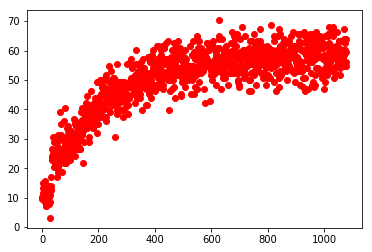

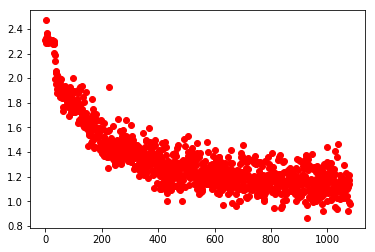

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

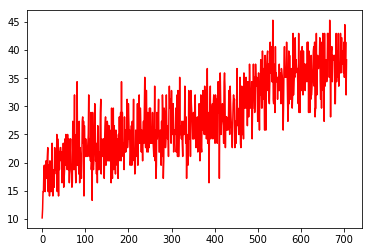

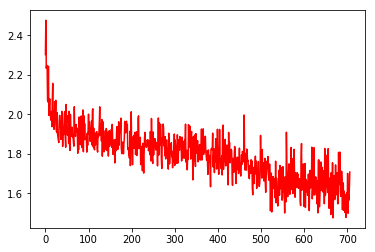

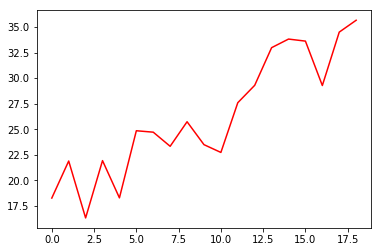

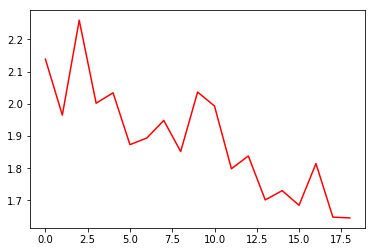

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()